# Курсовая работа<br> Аналитический отчет для продюссеров образовательных программ Skillbox
_________

[Описание работы](#Описание-работы) <br>
[Набор данных](#Набор-данных) <br>
[1. Описание и начальная работа с данными](#1.-Описание-и-начальная-работа-с-данными)<br>
[2. Расчет потенциальной нагрузки на преподавателей](#2.-Расчет-потенциальной-нагрузки-на-преподавателей)<br>
[3. Выявление проблемных модулей](#3.-Выявление-проблемных-модулей)<br>
[4. Расчет конверсии](#4.-Расчет-конверсии) <br>
[5. Метрика успеваемости ](#5.-Метрика-успеваемости)

## 1. Описание работы
Задача данной курсовой работы – на основании имеющихся данных подготовить аналитический отчет, который в дальнейшем поможет продюсерам образовательных программ эффективно выстраивать стратегию по модернизированию и улучшению курсов. 
<br><br>
В начале отчета предлагалось оформить емкий описательный блок по каждому курсу на основании рассчитанных показателей. Далее - посчитать потенциальную нагрузку на преподавателей, чтобы оценить необходимость расширения штата сотрудников. Затем идет блок из двух пунктов по анализу качества контента курсов, где необходимо выявить проблемные модули, которые, возможно, требуют доработки. Также стоит задача выявить потенциальную сезонность. 
В заключении, были разработаны метрики успеваемости студентов для нахождения тех, кто значительно хуже справляются с прохождением курса. 

Каждый из пунктов анализа сопровожден аналитическим выводом на основании рассчитанных метрик.


## Набор данных

`courses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `title` – название курса <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `field` – сфера, к которой относится курс <br> <br><br>
`students.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp; `city` – город студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `birthday` – день рождения студента <br> <br><br>
`course_contents.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `course_id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `module_title` – название модуля <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_title` – название урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_token` – токен урока <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `is_video` – наличие видео *(true/false)* <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `is_homework` – наличие домашней работы *(true/false)* <br>
<br><br>
`progresses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `student_id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `course_id` – идентификатор курса <br> <br><br>
`progress_phases.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `progress_id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `status` – статус прохождения урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `start_date` – дата начала <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `finish_date` – дата окончания <br>
<br><br>

## 1. Описание и начальная работа с данными

**Подготовка датасета**

Для начала необходимо объединить датасеты (кроме `students.scv`) в один общий для дальнейшей работы. Отдельный датасет создайте для расчета среднего возраста студентов курсов (отдельный датасет со `students.scv` нужен, чтобы в основном не потерять значения в основном датасете из-за того, что не по всем студентам есть анкетные данные о дате рождения). <br> 

Загружаем необходимые для анализа данных библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import re
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

Выгружаем данные из csv файлов для дальнейшего объединения. Удаляем лишние колонки с пустыми значениями.

In [2]:
df_courses = pd.read_csv('courses.csv')
df_courses = df_courses.loc[:, ~df_courses.columns.str.contains('^Unnamed')]
df_contents = pd.read_csv('course_contents.csv')
df_progresses = pd.read_csv('progresses.csv')
df_phases = pd.read_csv('progress_phases.csv')
df_students = pd.read_csv('students.csv')

Объединяем все датасеты, кроме df_students, удаляем колонки на основе которых происходило объединение и переименовывем колонки title > course_title и field > course_field

In [3]:
df_merged = df_phases.merge(df_progresses, how='inner', left_on='progress_id', right_on='id').merge(
            df_courses, how='left', left_on='course_id', right_on='id').merge(
            df_contents, how='left', on=['course_id', 'module_number', 'lesson_number']).drop(
            columns=['id_y', 'id_x']).rename(
            columns={'title':'course_title', 'field':'course_field'})

In [4]:
df_merged['finish_date'] = pd.to_datetime(df_merged['finish_date'])
df_merged['start_date'] = pd.to_datetime(df_merged['start_date'])

Отдельно создаем датасет df_students:

In [5]:
df_students.head()

,id_,id,city,birthday
0,1325,35e8a1938b9a33d5e45c8f4451c4309a,NaN,NaN
1,7503,6c3e52be632fc50de9640147e4017dcd,Москва,1979-10-23
2,8972,2033122d7c9b24b36eebc468d5259642,NaN,NaN
3,9235,a6ae278c0eab719b3784e5ea147c128f,Москва,NaN
4,9588,51b25c9afd20d178ef3c07276df38e2d,Великий Новгород,NaN


**1.1.** Найдем общее количество курсов на платформе Skillbox:

In [6]:
df_merged.course_id.nunique()

15

**1.2.** Найдем количество модулей на каждом курсе. Чтобы найти общее количество модулей на каждом курсе группируем датасет по названию курса и находим уникальные значения среди названий модулей:

In [7]:
df_merged.groupby('course_title')['module_title'].nunique().reset_index().sort_values('module_title')

,course_title,module_title
4,PHP-разработчик с 0 до PRO. Часть 1,8
8,Веб-вёрстка для начинающих 2.0,8
0,Excel Базовый,9
2,Java-разработчик c нуля,9
5,SMM-маркетолог от А до Я,11
1,Java-разработчик,17
9,Веб-дизайн PRO 2.0,17
10,Веб-дизайн Базовый,17
14,Руководитель digital-проектов,17
3,JavaScript с нуля,18


**1.3.** Найдем общее количество уроков в каждом модуле на каждом курсе. Для нахождения группируем датасет по ID курса, названию модуля и считаем уникальные значения а колонке названия уроков:

In [8]:
df_lessons = df_merged.groupby(['course_title','module_title'])['lesson_title'].nunique().reset_index().sort_values('lesson_title')
df_lessons

,course_title,module_title,lesson_title
158,Веб-дизайн с нуля 2.0,Бонус-модуль #2,1
186,Веб-разработчик,Дополнительные модули,1
82,UX-дизайн,Бонус-модуль. Эффектный кейс в 20 000 пикселей...,1
104,Анимация интерфейсов,Бонус-модуль. Экспорт анимации в код. Плагин B...,1
103,Анимация интерфейсов,Бонус-модуль. Практика: разбор кейса Уралсиб,1
...,...,...,...
207,Интернет-маркетолог от Ingate,Таргетированная реклама в социальных сетях,16
200,Интернет-маркетолог от Ingate,Контекстная реклама в Yandex Direct и Google A...,17
195,Интернет-маркетолог от Ingate,"SEO: больше, чем поисковая выдача (обновление ...",19
34,Java-разработчик c нуля,"Числа, строки и даты",27


**1.4.** Найдем медианное количество уроков на курсе. Берем полученный датасет из предыдущего шага и группируем его только по ID курса и находим медианное значение по каждому курсу:

In [9]:
df_lessons.groupby('course_title')['lesson_title'].median().reset_index()

,course_title,lesson_title
0,Excel Базовый,5.0
1,Java-разработчик,7.0
2,Java-разработчик c нуля,10.0
3,JavaScript с нуля,7.0
4,PHP-разработчик с 0 до PRO. Часть 1,4.0
5,SMM-маркетолог от А до Я,6.0
6,UX-дизайн,3.5
7,Анимация интерфейсов,3.0
8,Веб-вёрстка для начинающих 2.0,7.0
9,Веб-дизайн PRO 2.0,5.0


**1.5.** Для поиска общего количества учеников на каждом курсе группируем основной датасет по названию курса и подсчитываем уникальные значения в колонке с ID студента

In [10]:
df_merged.groupby('course_title')['student_id'].nunique().reset_index().sort_values('student_id')

,course_title,student_id
5,SMM-маркетолог от А до Я,506
10,Веб-дизайн Базовый,518
2,Java-разработчик c нуля,581
7,Анимация интерфейсов,598
12,Веб-разработчик,628
14,Руководитель digital-проектов,685
1,Java-разработчик,763
0,Excel Базовый,782
4,PHP-разработчик с 0 до PRO. Часть 1,854
3,JavaScript с нуля,966


**1.6.** Находим минимальный, максимальный, средний, медианный возраст студентов. Для этого необходимо подготовить датасет - сохранить в переменную today сегодняшнюю дату, отчистить датасет от пустых значений в колонке birthday и переформатировать ее. Затем создаем колонку age и вычисляем возраст каждого студента на сегодняшний день. 
Заметив, что в датасете есть некорректные значения (дата рождения в будущем или далеко в прошлом) ограничим возраст студентов - возьмем возраст старше 16 и младше 80 лет. Именно в этом возрасте человек скорее всего использует платформу Skillbox

In [11]:
today = pd.Timestamp('today')
df_ages = df_students[(df_students['birthday'].notnull())].copy()
df_ages['birthday'] = pd.to_datetime(df_ages['birthday'], errors='coerce')
df_ages['age'] = round((today - df_ages['birthday']) / np.timedelta64(1, 'Y'))

In [12]:
df_ages = df_ages[(df_ages['age'] > 16) & (df_ages['age'] < 80)]

In [13]:
df_ages['age'].agg(['min', 'max', 'mean', 'median'])

min       17.000000
max       78.000000
mean      31.530216
median    31.000000
Name: age, dtype: float64

**1.7.** Найдем минимальный, максимальный, средний, медианный возраст студентов на каждом курсе: 

In [14]:
df_merged_with_ages = df_merged.merge(df_ages, how='inner', left_on='student_id', right_on='id')

In [15]:
df_merged_with_ages.groupby('course_title')['age'].agg(['min', 'max', 'mean', 'median']).reset_index()

,course_title,min,max,mean,median
0,Excel Базовый,18.0,63.0,35.458222,35.0
1,Java-разработчик,17.0,67.0,31.949463,31.0
2,Java-разработчик c нуля,17.0,57.0,32.218463,31.0
3,JavaScript с нуля,17.0,61.0,30.898841,30.0
4,PHP-разработчик с 0 до PRO. Часть 1,17.0,77.0,33.331849,32.0
5,SMM-маркетолог от А до Я,19.0,54.0,31.143700,31.0
6,UX-дизайн,17.0,60.0,32.527729,32.0
7,Анимация интерфейсов,17.0,53.0,32.050549,32.0
8,Веб-вёрстка для начинающих 2.0,17.0,61.0,30.976237,30.0
9,Веб-дизайн PRO 2.0,17.0,61.0,30.728424,29.0


**1.8.** Построим bar-chart, отражающий количество студентов на каждом курсе. 

In [16]:
course_students = df_merged.groupby('course_title')['student_id'].nunique().reset_index().sort_values('student_id')
course_students

,course_title,student_id
5,SMM-маркетолог от А до Я,506
10,Веб-дизайн Базовый,518
2,Java-разработчик c нуля,581
7,Анимация интерфейсов,598
12,Веб-разработчик,628
14,Руководитель digital-проектов,685
1,Java-разработчик,763
0,Excel Базовый,782
4,PHP-разработчик с 0 до PRO. Часть 1,854
3,JavaScript с нуля,966


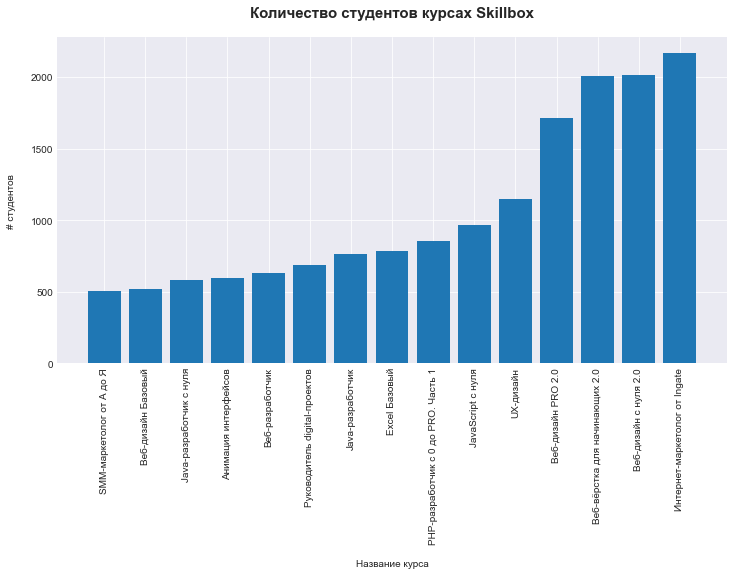

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(course_students['course_title'], course_students['student_id'])
plt.title('Количество студентов курсах Skillbox', fontweight="bold", pad=20, fontsize=15)
plt.xlabel('Название курса', labelpad=15)
plt.ylabel('# студентов', labelpad=15)
plt.xticks(rotation=90);

**1.9** В bar-chartе ниже представлено количество студентов на каждом курсе, сгруппированые по направлениям обучения.

In [18]:
course_students2 = df_merged.groupby(['course_field', 'course_title'])['student_id'].nunique().reset_index().sort_values('student_id')
course_fields = list(course_students2.course_field.unique())

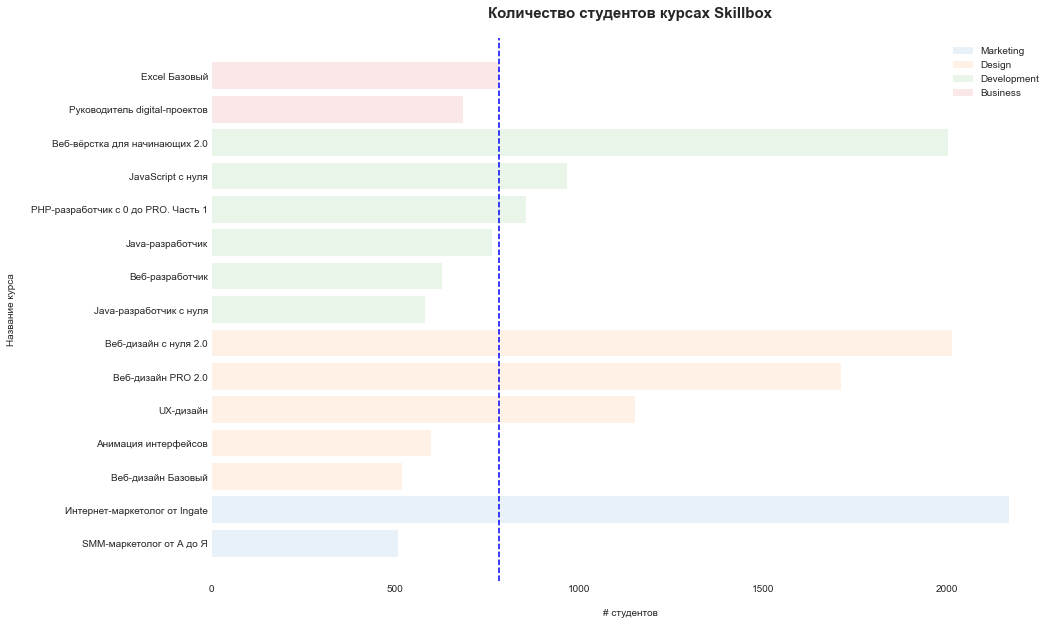

In [19]:
plt.figure(figsize=(15,10))
for i in range(len(course_fields)):
    plt.barh(course_students2[course_students2['course_field'] == course_fields[i]].course_title, 
             course_students2[course_students2['course_field'] == course_fields[i]].student_id, 
             label=course_fields[i],
             alpha=0.1)
median = int(course_students2['student_id'].median())
plt.axvline(x=median, linestyle='--', color='b')
plt.title('Количество студентов курсах Skillbox', fontweight="bold", pad=20, fontsize=15)
plt.xlabel('# студентов', labelpad=15)
plt.ylabel('Название курса', labelpad=15)
plt.box(on=None)
plt.legend(loc='upper right')
plt.show()

**1.10.** На основании рассчитанных значений можно сделать следующие выводы:<br>
- Общее количество курсов на платформе Skillbox - 15
- Все курсы на платформе состоят из нескольких модулей, которые в свою очередь содержат различные уроки. Так, курс "Анимация интерфейсов" содержит наибольшее количество модулей - 21. Среднее количество уроков в каждом модуле - 7. 
Курс "PHP-разработчик с 0 до PRO. Часть 1" наоборот состоит из наименьшего количества модулей, восьми, которые содержат в среднем 4 урока. Это может быть связано с тем, что курс разделен на несколько частей.
- Больше всего уроков содержит курс "Java-разработчик c нуля", который состоит из 17 модулей и в среднем содержит 10 уроков в модуле. Для модуля "Числа, строки и даты" было создано 27 уроков. Если рассматривать самый большой по количеству уроков модуль(не курс), то им является модуль "Email-маркетинг" на курсе "Интернет-маркетолог от Ingate". Это может быть связано с необходимостью частого закрепления пройденного материала на практике, так как чаще всего к каждому уроку на платформе Skillbox идет дополнительное практическое задание.
- Как было сказано выше, из датасета с информацией о возрасте студентов были удалены некорректные данные (дата рождения в будущем или далеко в прошлом). В датасете были сохранены данные о студентах от 16 до 80 лет. Именно в этом возрасте человек скорее всего использует платформу Skillbox<br>
Так, минимальный возраст студентов - 17 лет<br>
Максимальный возраст - 77 лет<br>
Среднее и медианное значения идентичны - 31 год<br>
В рассчитанных значениях наиболее интересным кажется средний возраст студентов. Skillbox является платформой, которая популяризирует обучение новым профессиям с последующим трудоустройством/изменения в карьере. Чаще всего это интересно людям, которые уже начали свой трудовой путь после окончания университета, но не удовлетворены своим первоначальным выбором. Так, в 30 лет люди не боятся перемен и готовы изучать что-то новое. Этим обуслоленно медианное значение возраста студентов. 
- Из графиков, представляющих общее количество студентов, видно, что курсы по интернет-маркетингу от Ingate являются самыми популярными среди студентов Skillbox. Более 2х тысяч человек обучаются на данном курсе. Это может быть свзяано с популярностью такого направления как маркетинг в целом. На сегодняшний день все больше людей готовы открыть свой собственный бизнес и заинтересованы в эффективных продажах. А также популярность курса может быть обусловлена тем, что курс является совместной программой с известным маркетинговым агенством Ingate, что могло вызвать интерес у студентов. Стоит отметить, что курс "SMM-маркетолог от А до Я" является, напротив, самым непопулярным курсом (506 человек). Данную закономерность можно объяснить узкой направленностью данного курса и высокой конкуренцией на рынке SMM-маркетинга и болшое количество бесплатных курсов по данной теме. 
- В топе курсов также находятся курсы по веб-дизайну и веб-верстке. С другой стороны, базовый курс веб-дизайна является одним из самых непопулярных. Причной низкой популярности базового курса и высокой популярности продвинутых курсов может быть самостоятельное изучение основ веб-дизайна на бесплатных платформах и запрос на более углубленные знания. 
- Рассматривая статистику по курсам, группируя их по направлениям, можно сделать вывод, что популярным направлением на платформе является Дизайн. Общее количество студентов, зарегистрированных на курсы Веб-Дизайн 2.0, Веб-Дизайн PRO и UX-дизайн является выше среднего. Програмирование также является одним из самых популярных направлений, где на 3 курса из 6 зарегистрировано более 750 человек. Это может быть обусловленно современными трендами современности.
- Бизнес-направление на платформе представлено двумя курсами - Базовый Excel и Руководитель Digital-проектов. Общее количество студентов, обучающихся на данных курсах, составляет ниже среднего. Данные показатели можно связать с большим количеством базовых курсов по Excel в бесплвтном доступе и узкая направленность курса по руководству Digital-проектов.

## 2. Расчет потенциальной нагрузки на преподавателей
<br><br>
**2.1.** Рассчитаем прирост студентов на каждом курсе в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно). Как начало прохождения курса берется старт первой домашней работы. Для большинства курсов это старт работы над домашним заданием первого модуля. Для курса Веб-Дизайн Базовый - домашним заданием 3го модуля, так как первые два модуля не предполагают выполнение домашней работы. Подсчитываем количество студентов, начавших домашнее задание, в каждом месяце.

In [20]:
course_list = list(df_merged.course_title.unique())
course_field_list = list(df_merged.course_field.unique())
df_merged['start_date'] = pd.to_datetime(df_merged['start_date'])
df_merged['finish_date'] = pd.to_datetime(df_merged['finish_date'])

In [21]:
df_growth = df_merged[((df_merged['is_homework'] == True) & (df_merged['module_number'] == 1)) | 
                     ((df_merged['course_title'] == 'Веб-дизайн Базовый') & (df_merged['module_number'] == 3) 
                      & (df_merged['is_homework'] == True))].copy()
df_growth['month'] = df_growth['start_date'].dt.to_period('M').astype(str)
df_growth_table = pd.pivot_table(df_growth, values=['student_id'], index=['month'], columns=['course_title'], 
                                 aggfunc={'student_id': 'count'})
df_growth_table.columns = [col[1] for col in df_growth_table.columns.values]
df_growth_table = df_growth_table.reset_index()
months_list = list(df_growth_table.month)

/Users/mariaonishchuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


**2.2.** На основании первого пункта строим line-graph-ы с приростом студентов в каждом месяце для каждого курса.

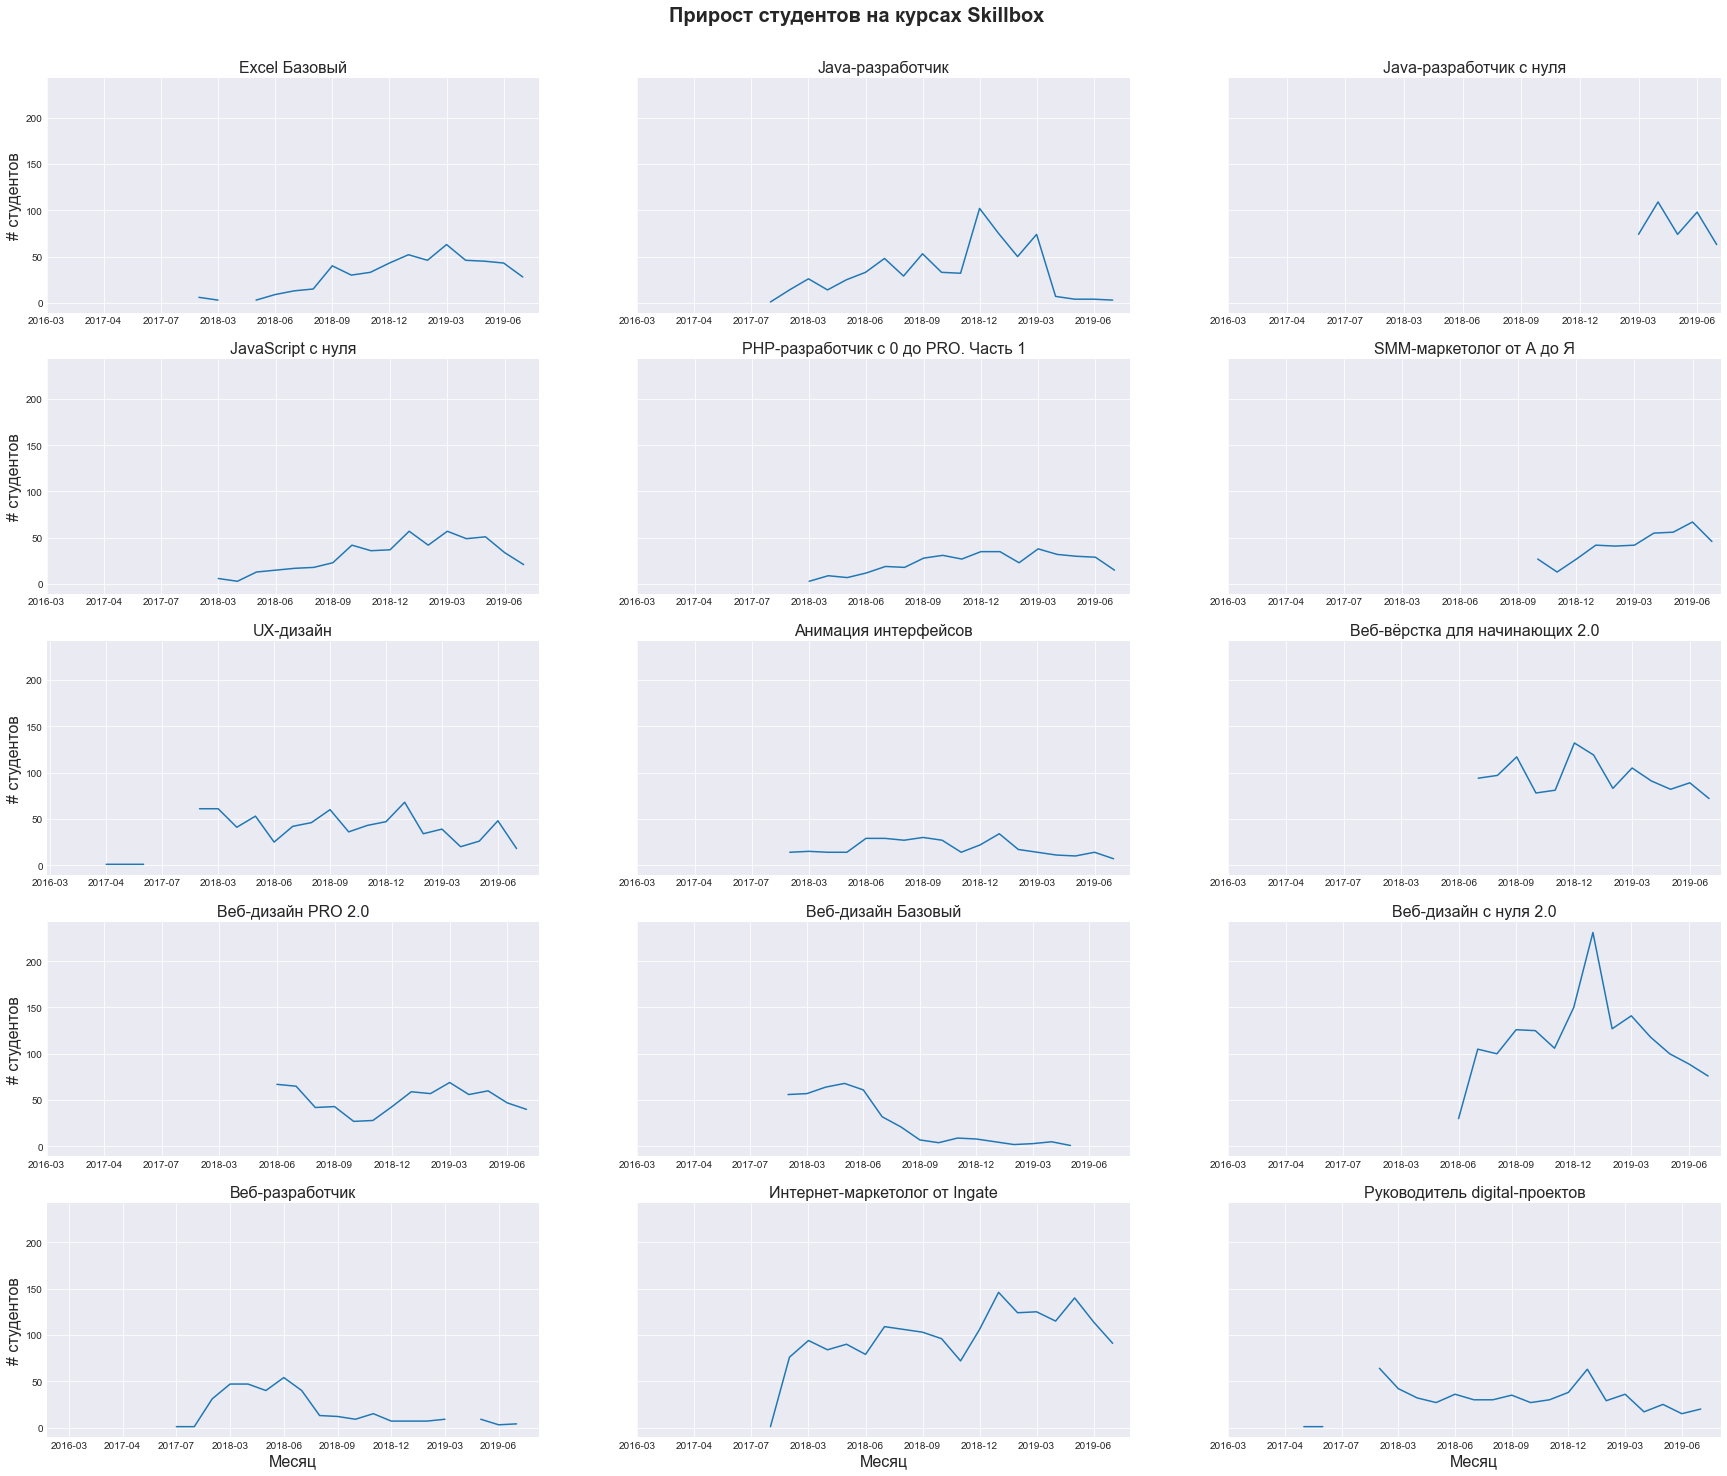

In [22]:
fig, axs = plt.subplots(figsize=(30, 25), nrows=5, ncols=3, sharey=True)
course_list = list(df_growth_table.columns)[1::]
course=0

for i in range(5):
    for j in range(3):
        ax=axs[i][j]
        ax.plot(df_growth_table['month'], df_growth_table[course_list[course]])
        ax.set_title(course_list[course], fontsize=16)
        if i == 4:
            ax.set_xlabel('Месяц', fontsize=16)
        if j == 0:
            ax.set_ylabel('# студентов', fontsize=16)
        ax.set_xticks(months_list[::3])
        course += 1
fig.suptitle('Прирост студентов на курсах Skillbox', y=0.92, fontsize=20, fontweight='bold')
plt.show()

**2.3.** Сторим объединенный line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 

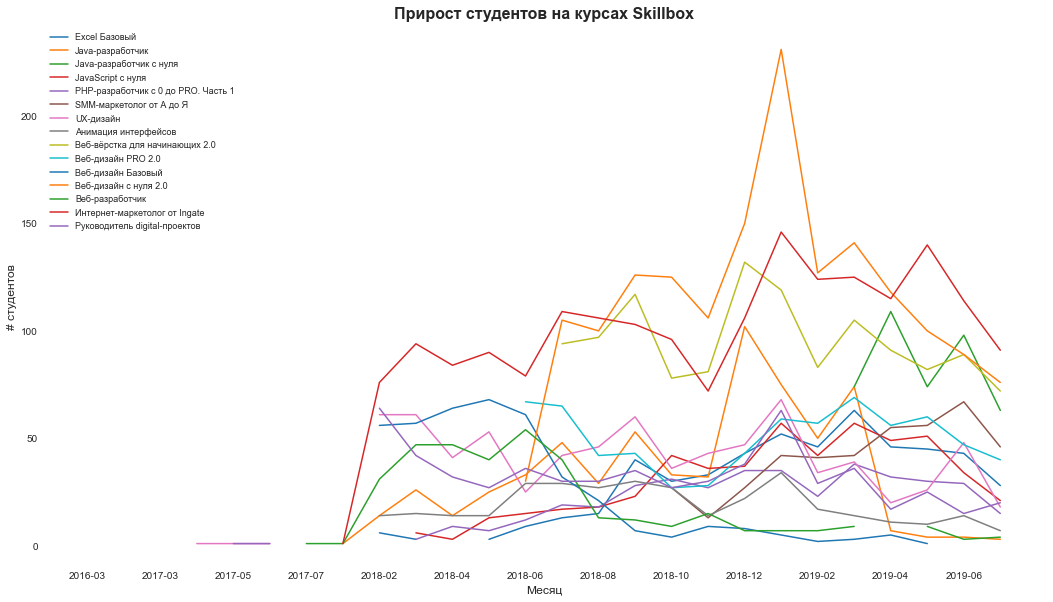

In [23]:
fig, ax = plt.subplots(figsize=(18,10))
for course in course_list:
    ax.plot(df_growth_table['month'], df_growth_table[course], label = course)
    ax.set_xticks(months_list[::2])
    ax.set_title('Прирост студентов на курсах Skillbox', fontsize=16, fontweight='bold')
    ax.set_xlabel('Месяц', fontsize=12)
    ax.set_ylabel('# студентов', fontsize=12)
ax.legend(loc = "upper left", fontsize=9)
plt.box(on=None)
plt.show()

**2.4.** Рассчитываем количество прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса. При подсчете учитываем, что выполнение домашнего задания может перетекать из одного месяца в другой.

In [24]:
df_hw = df_merged[(df_merged['finish_date'].notnull()) & (df_merged['is_homework'] == True)].copy()

df_hw['month'] = df_hw.apply(lambda x: pd.date_range(x.start_date.strftime("%Y-%m"), x.finish_date.strftime("%Y-%m"), freq='MS').strftime("%Y-%m").tolist(), axis=1)
df_hw = df_hw.explode('month')

In [25]:
df_progress = pd.pivot_table(df_hw, values=['lesson_title'], index=['month'], columns=['course_title'], 
                                 aggfunc={'lesson_title': 'count'})

df_progress.columns = [col[1] for col in df_progress.columns.values]
df_progress = df_progress.reset_index()
df_progress['month'] = df_progress['month'].astype(str)
months_list1 = list(df_progress.month)
course_list1 = list(df_progress.columns)[1::]

**2.5.** Строим line-graph для визуализации количества прогрессов по выполнению домашних работ в каждом месяце за всю историю

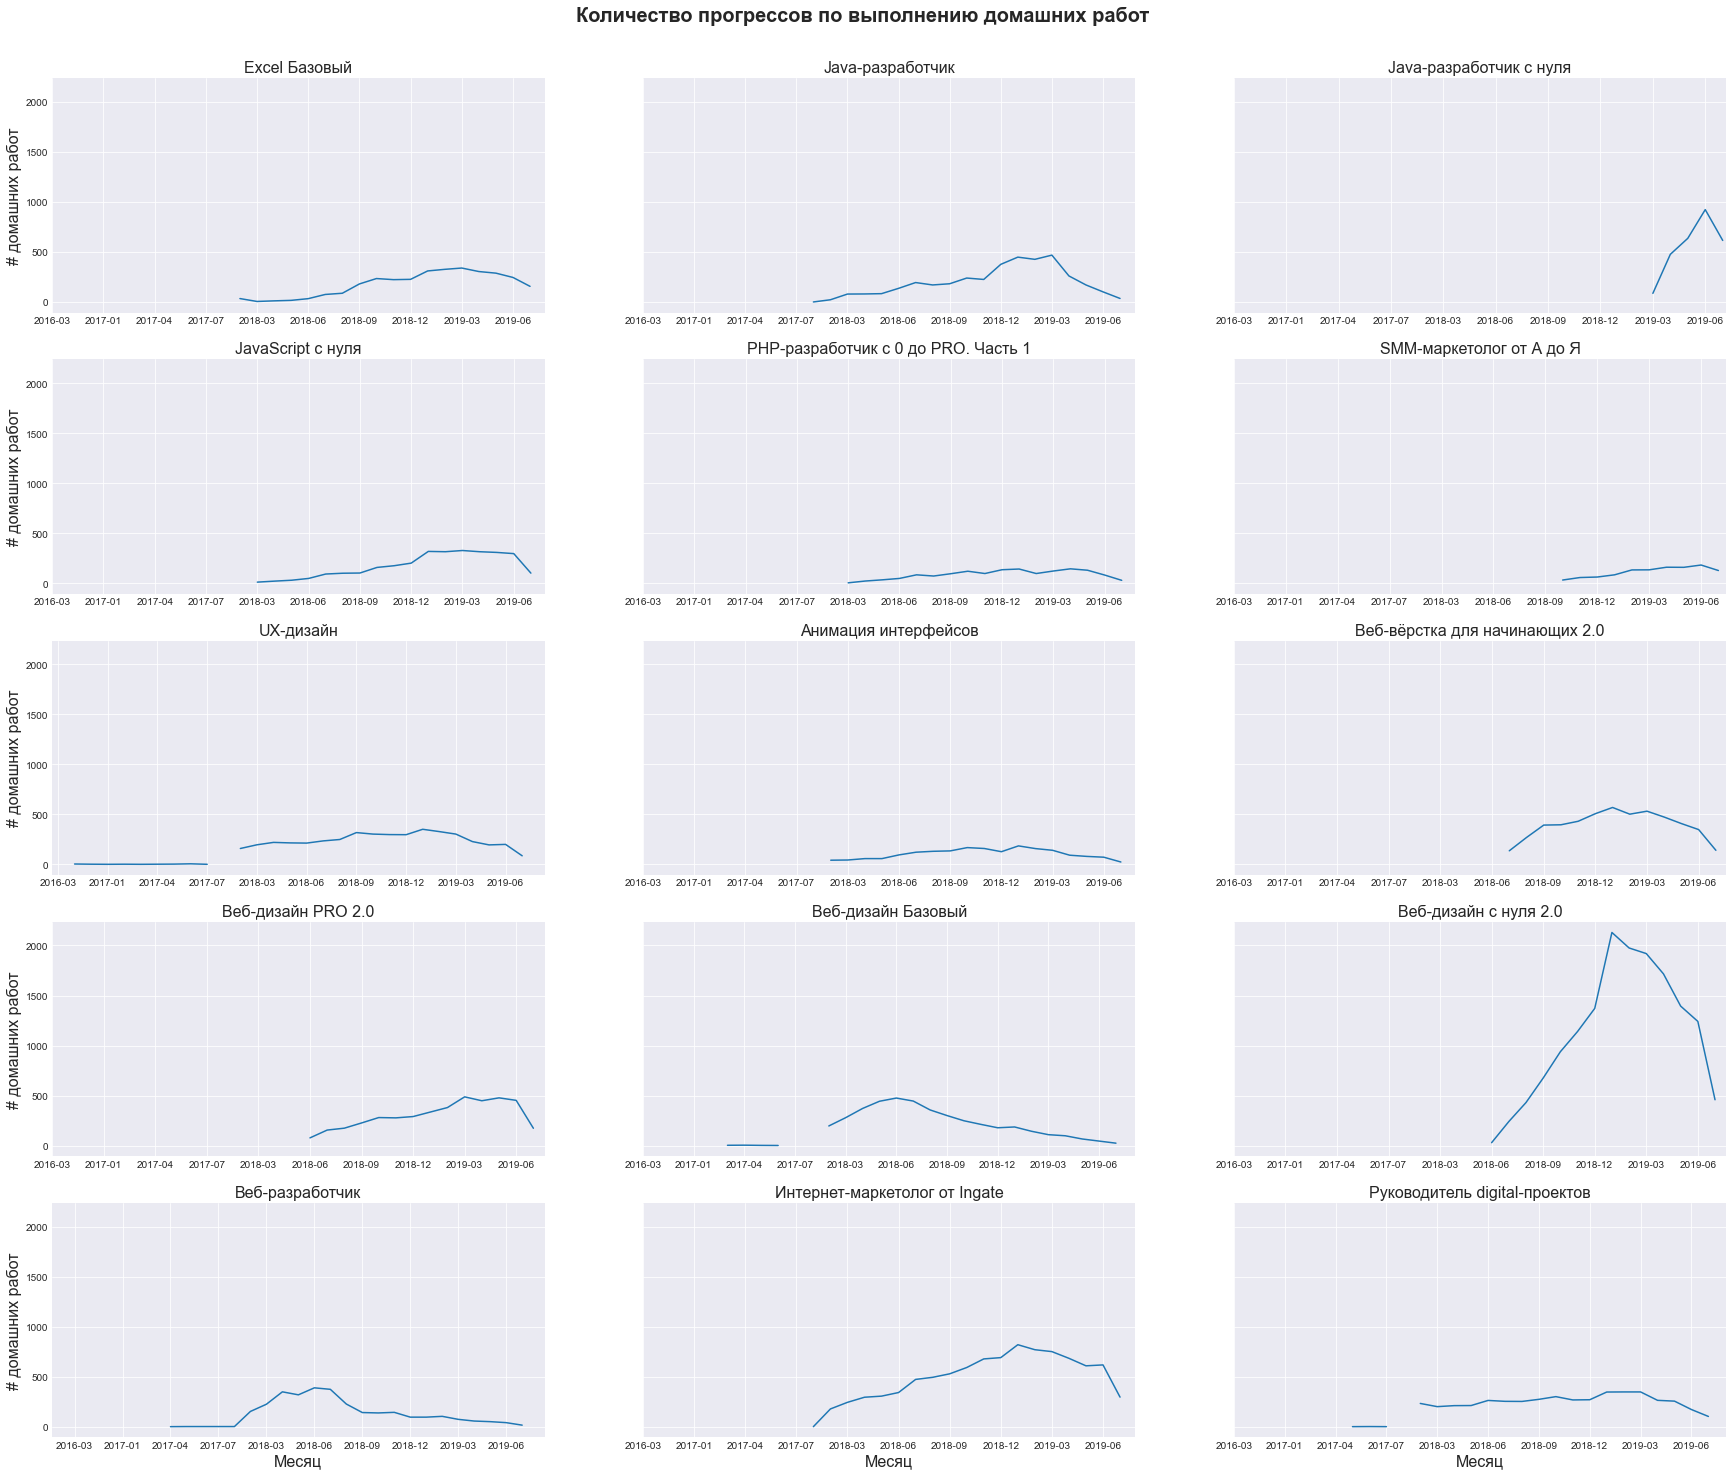

In [26]:
fig, axs = plt.subplots(figsize=(30, 25), nrows=5, ncols=3, sharey=True)
course=0
for i in range(5):
    for j in range(3):
        ax=axs[i][j]
        ax.plot(df_progress['month'], df_progress[course_list1[course]])
        ax.set_title(course_list1[course], fontsize=16)
        if i == 4:
            ax.set_xlabel('Месяц', fontsize=16)
        if j == 0:
            ax.set_ylabel('# домашних работ', fontsize=16)
        ax.set_xticks(months_list1[::3])
        course += 1
fig.suptitle('Количество прогрессов по выполнению домашних работ', y=0.92, fontsize=20, fontweight='bold')
plt.show()

**2.6.** Построим объединенный line-graph для всех курсов для визуализации количества прогрессов по выполнению домашних работ в каждом месяце за всю историю 

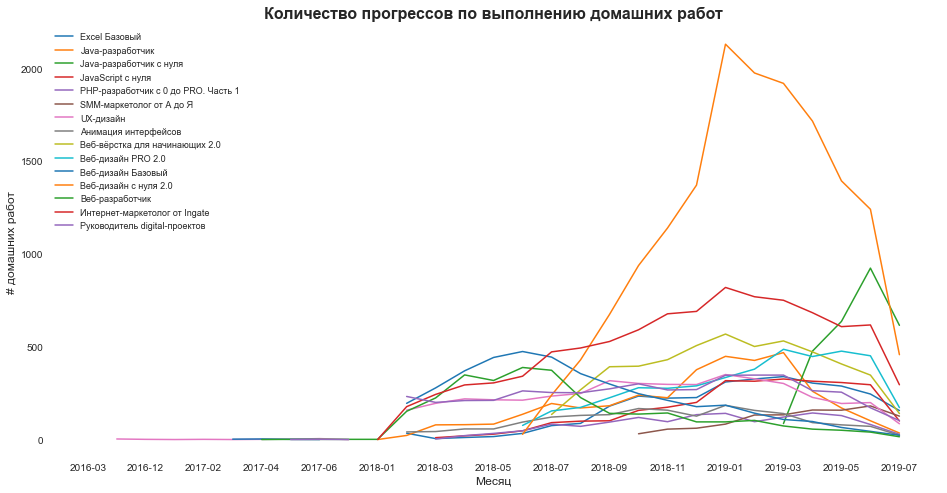

In [27]:
fig, ax = plt.subplots(figsize=(16,8))
for course in course_list1:
    ax.plot(df_progress['month'], df_progress[course], label = course)
    ax.set_xticks(months_list1[::2])
    ax.set_title('Количество прогрессов по выполнению домашних работ', fontsize=16, fontweight='bold')
    ax.set_xlabel('Месяц', fontsize=12)
    ax.set_ylabel('# домашних работ', fontsize=12)
ax.legend(loc = "upper left", fontsize=9)
plt.box(on=None)
plt.show()

**2.7.** На основании рассчитанных значений можно сделать следующие выводы:
- Активные продажи большинства курсов, представленных в датасете, начались в июле 2017 года. 
- В целом, мы наблюдаем рост продажи курсов в период с июля 2017 года по март 2018 года:
* Так, самый высокий прирост показал курс "Интернет-маркетолог от Ingate", достигая приблизительно 100 человек в марте 2018 года. 
* От 50 до 60 студентов к марту 2018 года начали курсы "Руководитель digital-проектов", "Веб-Дизайн Базовый", "UX-дизайн". 
* От 0 до 10 студентов начали работу над курсами "Анимация интерфейсов", "PHP-разработчик с 0 до PRO. Часть 1", "JavaScript с нуля". 


Несколько курсов из данного датасета были запущены позже:
* Два курса по веб-дизайну (с нуля и PRO) начались в июне 2018 года. Курс для продвинутых приобрели больше 60 челоевек, а курс для новичков - 30 человек.
* "Веб-верстка для начинающих" - чуть меньше ста человек приобрели курс к июлю 2018 года 
* "SMM-маркетолог от А до Я" начался в октябре 2018 года с менее 30 студентами
* "Java-разработчик с нуля" - около 70 студентов приобрели курс в марте 2019 года 

**Таким образом, самые высокие стартовые продажи показали курсы "Java-разработчик с нуля" с 74 студентами в первый месяц продаж и "Веб-вёрстка для начинающих 2.0" с 94 студентами.**

Рассматривая прирост студентов курсов Skillbox, можно заметить умеренный рост количества студентов к январю 2019 года с дальнейшим спадом к июню 2016 года. Данный тренд может быть обусловлен тем, что к началу 2019 года платформа Skillbox набрала популярность в России, а также возможными новогодними распродажами курсов. Еще одним объяснением данного тренда может быть активный интерес людей к саморазвитию/обучению к началу нового года. 

Из графиков прироста студентов можно сделать также следующие выводы:
* Можно увидеть закономерность между приростом студентов курсов "Веб-дизайн базовый" и "Веб-дизайн с нуля 2.0". В то время как количество студентов на втором курсе растет, прирост студентов на базовом крусе значительно снижается. Данная закономерность может быть свзяана с улучшением базового курса и создание двух отдельных - "Веб-дизайн с нуля 2.0" и "Веб-дизайн PRO 2.0"
* Самый высокий прирост студентов показывает курс "Веб-дизайн с нуля 2.0" в январе 2019 года. В период с декабря 2018 по январь 2019 года количество студентов, начавших курс, выросли со 150 до 230. 
* Умеренный прирост наблюдается на курсах "Руководитель digital проектов", "Анимация интерфейсов", "PHP разработчик с 0 до PRO", "Java-Script с нуля", "Excel базовый". При этом количество студентов на данных курсах не превышает 60 человек за весь период продаж.

Анализируя графики, отображающие прогрессы по домашним заданиям, мы можем сделать следующие выводы:
* Статистика прогрессов домашних работ частично повторяет тренд прироста студентов курсов.
* Высокий прирост количества домашних работ за период с июня 2018 по январь 2019 наблюдается на курсах "Интернет-маркетолог от Ingate" и "Веб-дизайн с нуля 2.0", а также на курсе "Java-разработчик с нуля" за период март-июнь 2019. Данный тренд напрямую заисит от прироста студентов на курсе. 
* Количество прогрессов по домашним работам на остальных курсах не превышает 500 и идет на спад в июне 2016 года. 

**Из описанного выше можно сделать вывод, что к началу календарного года наблюдается активный прирост студентов, начинающих курсы Skillbox, в свзяи с чем растет и количество сданных домашних заданий. С началом летнего сезона активность студентов курса снижается - ниже продажи курсов и ниже количество домашних работ. Данную информацию необходимо учитывать при планировании нагрузки преподавателей. Также стоит учитывать популярность отдельных курсов - курсы по инетрнет-маркетингу, курс веб-дизайна для начинающих и курс для начинающих Java-разработчиков** 

## 3. Выявление проблемных модулей


**3.1** Для начала рассчитаем минимальное, максимальное, среднее, медианное время прохождения каждого модуля для каждого курса. Если домашних заданий в модуле несколько, то считаем разность между временем начала выполнения первой домашней работы и временем окончания выполнения последней домашней работы в модуле. При этом удаляем некорретные значения в датасете - данные по домашним заданиям, где начало выполнения домашней работы позже либо равно окончанию выполнения домашней работы.

In [28]:
df_module_data = df_merged[(df_merged['is_homework'] == True) & 
                           (df_merged['status'] == 'done')].groupby(
    ['course_title', 'module_number', 'progress_id']).agg(
    {'start_date': 'min', 'finish_date':'max'}).reset_index().copy()
df_module_data['module_duration'] = (df_module_data['finish_date'] - df_module_data['start_date']).astype('timedelta64[h]')
df_module_data = df_module_data.drop(df_module_data.index[df_module_data['start_date'] >= df_module_data['finish_date']])

In [29]:
df_module_table = df_module_data.groupby(
    ['course_title', 'module_number'])['module_duration'].agg(['min', 'max', 'mean', 'median']).reset_index()

**3.2.** На основе данных из предыдущего пункта строим line-graph с медианным временем прохождения каждого модуля для каждого курса.

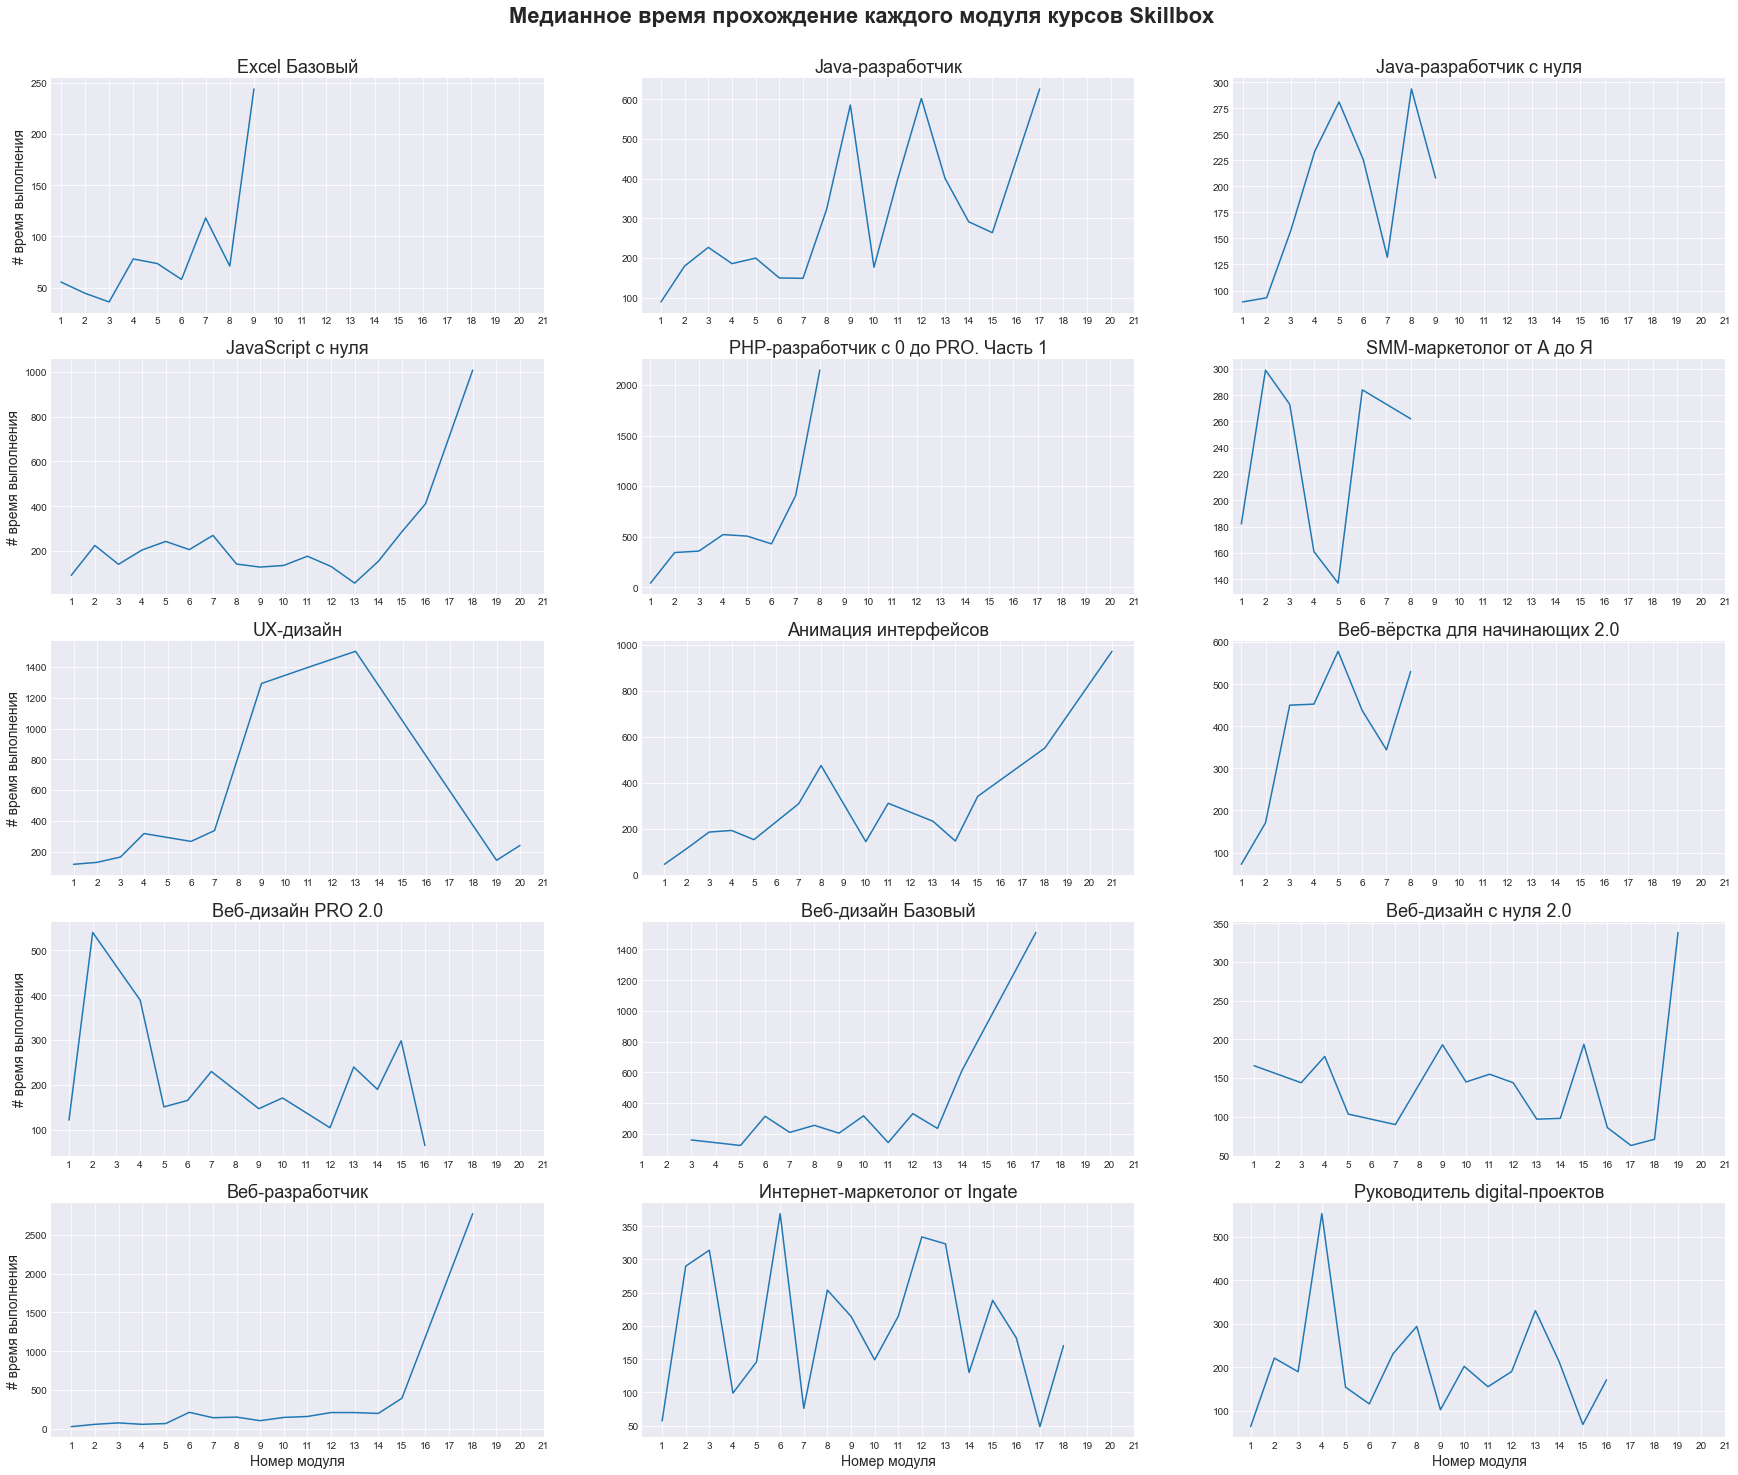

In [30]:
fig, axs = plt.subplots(figsize=(30, 25), nrows=5, ncols=3)
course=0
for i in range(5):
    for j in range(3):
        ax=axs[i][j]
        ax.plot(df_module_table[df_module_table['course_title'] == course_list[course]]['module_number'],
                df_module_table[df_module_table['course_title'] == course_list[course]]['median'])
        ax.set_xticks(list(df_module_table.module_number.unique()))
        ax.set_title(course_list[course], fontsize=18)
        if i == 4:
            ax.set_xlabel('Номер модуля', fontsize=14) 
        if j == 0:
            ax.set_ylabel('# время выполнения', fontsize=14)
        course += 1
fig.suptitle('Медианное время прохождение каждого модуля курсов Skillbox', y=0.92, fontsize=22, fontweight='bold')
plt.show()

**3.3.** Для выявления сезонности посчитаем медианное время выполнения домашней работы по месяцам для каждого курса.

In [31]:
df_module_data['month'] = df_module_data.apply(lambda x: x['finish_date'].month, axis=1)

In [32]:
df_module_table1 = df_module_data.groupby(
    ['course_title', 'month'])['module_duration'].median().reset_index()

In [33]:
df_module_table1 = pd.pivot_table(df_module_table1, values=['module_duration'], 
                                  index=['month'], columns=['course_title'])
df_module_table1.columns = [col[1] for col in df_module_table1.columns.values]
df_module_table1 = df_module_table1.reset_index()

**3.4.** На основе данных из третьего пункта строим объединенный line-graph для визуализации медианного времени выполнения домашней работы по месяцам.

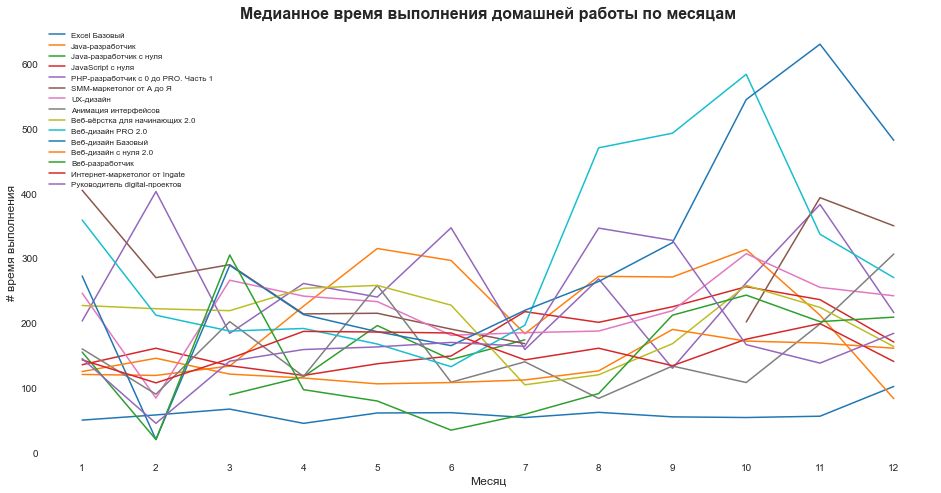

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
for course in course_list:
    ax.plot(df_module_table1['month'], df_module_table1[course], label = course)
    ax.set_xticks(df_module_table1.month)
    ax.set_title('Медианное время выполнения домашней работы по месяцам', fontsize=16, fontweight='bold')
    ax.set_xlabel('Месяц', fontsize=12)
    ax.set_ylabel('# время выполнения', fontsize=12)
ax.legend(loc = "upper left", fontsize=8)
plt.box(on=None)
plt.show()

**3.5.** На основании рассчитанных значений можно сделать следующие выводы:
- Наблюдается резкий скачок медианного времени прохождения последнего модуля каждого курса кроме "Веб-дизайн PRO 2.0.", 'SMM-маркетолог от А до Я' и "Java-разработчик с нуля". Предположим, что последним модулем чаще всего является дипломная работа по курсу, выполнение которой занимает намного больше времени.
Чтобы выявить точную причину роста/спада значений медианного времени, найдем названия данных модулей:

In [35]:
module_names = df_merged.groupby(['course_title', 'module_number'])['module_title'].last().reset_index()
module_names.groupby('course_title')['module_title'].last().reset_index()

,course_title,module_title
0,Excel Базовый,Экзаменационная работа
1,Java-разработчик,Итоговая тема
2,Java-разработчик c нуля,Работа с файлами и сетью
3,JavaScript с нуля,Экзаменационное задание
4,PHP-разработчик с 0 до PRO. Часть 1,Курсовая работа
5,SMM-маркетолог от А до Я,Информация о дипломном проекте
6,UX-дизайн,Экзаменационная тема
7,Анимация интерфейсов,Дипломная работа
8,Веб-вёрстка для начинающих 2.0,Инструменты верстальщика
9,Веб-дизайн PRO 2.0,Информация о дипломном проекте


* Таким образом, мы видим, что курсы, которые заканчиваются проверочной работой (экзамен или курсовая/дипломная/экзаменационная работа), показывают значительный рост медианного времени выполнения данного модуля. Так, студенту требуется больше времени для подготовки заключительной работы. К примеру, среднее выполнение проверочной работы в курсе для веб-разработчиков составляет более 2000 часов.
* В большинстве случаев первые три модуля выполняются сравнительно быстро - медианное время прохождения модулей варьируется от 50часов (около 2х дней) до 300 часов (около 12 дней).
* Быстрее всего студенты проходят курс "Excel Базовый". В среднем студентам необходимо чуть больше 100 часов для прохождения обычных модулей и около 250 часов для выполнения экзаменационной работы. 
* Больше всего времени студентам требуется для прохождения курса "UX Дизайн". Начиная с 7го модуля студентам требуется от 500 до 1500 часов для прохождения модуля. С 17 модуля медианное значение времени снижается.
* Сложными проверочными работами можно считать проверку в рамках курса "Веб-разработчик", а также курсовую работу курса "PHP-разработчик с 0 до PRO. Часть 1". Медианное время прохождения модулей составляет свыше 2000 часов
* На некоторых графиках мы видим резкие скачки в медианном времени. Так, например, на курсе "UX-дизайн" можно заметить резкий рост времени выполнения модулей с 9 по 13, за которым следует такое же резкое падение. На курсах "Java-разработчик" и "Java-разработчик с нуля" также есть модули, которые проходятся намного дольше остальных. С учетом того, что чаще всего время выполнения напрямую зависит от сложности заданий, можно предположить, что у студентов возникают сложности с подготовкой домашнего задания. 

Анализируя график, представляющий медианное время выполнения домашней работы по месяцам, можно отметить следующие тенденции:
* В январе студентам необходимо больше времени для подготовки домашних заданий. Медианное время выполнение в среднем составляет 150-400 часов. Данное значение можно объяснить долгими новогодними каникулами в России, во время которых студенты, скорее всего, не находят времени для подготовки заданий и возвращаются к ним позже. Действительно, в феврале мы наблюдаем спад медианного времени, в среднем до 20-120 часов. 
* В июне и июле также заметно снижение времени выполнения домашних заданий, что может быть обсуловлено частыми отпусками в летнее время, когда у студентов есть больше времени для учебы и более быстрого выполнения домашних заданий. Затем с августа по ноябрь в большинстве курсов наблюдается умеренный рост медианного времени за которым снова следует небольшое снижение в декабре.

**Обобщая вышесказанное, можно отметить, что при планировании ресурсов преподавателей и подготовке материалов курсов необходимо учитывать общее время прохождения курса, медианное время выполнение каждого модуля и проверочных работ, так как это напрямую зависит от сложности материала, а также сезонность - в осенне-зимнее время эффективность студентов снижается, в то время как летом эффективность и скорость выполнение заданий повышается**


## 4. Расчет конверсии


**4.1.** Посчитаем конверсию перехода студентов из одного модуля в другой на каждом курсе. При подготовке датасета удаялем информацию о 1 модуле. Исключением является курс 'Веб-дизайн Базовый', где первое домашнее задание появляется только в 3 модуле.

In [36]:
df_conversion = df_merged[(df_merged['is_homework'] == True) &
                          (df_merged['status'] == 'done')]
df_conversion = df_conversion.groupby(['course_title', 'student_id', 'module_number' 
                                       ])[['start_date', 'finish_date']].agg({'start_date': 'min', 
                                                                              'finish_date': 'max'}).reset_index()

In [37]:
df_conversion_data = df_conversion.groupby(['course_title', 
                                            'module_number'])[['start_date', 
                                                              'finish_date']].agg({'start_date': 'count', 
                                                                                  'finish_date': 'count'}).reset_index()
df_conversion_data['change'] = df_conversion_data['start_date'] / df_conversion_data['finish_date'].shift()
df_conversion_data = df_conversion_data.drop(df_conversion_data.index[df_conversion_data['module_number'] == 1])
df_conversion_data = df_conversion_data.drop(df_conversion_data.index[(df_conversion_data['course_title'] == 'Веб-дизайн Базовый') &
                                            (df_conversion_data['module_number'] == 3)])
df_conversion_data.replace(np.inf, 0, inplace=True)
df_conversion_table = df_conversion_data.groupby('course_title')['change'].mean().reset_index().sort_values('change')

In [38]:
df_module_names = df_merged.groupby(['course_title', 'module_number'])[['module_title', 'course_field']].first().reset_index()
df_conversion_table2 = df_conversion_data.merge(df_module_names, how='inner', on=['course_title', 'module_number'])
df_conversion_table2['module_title'] = df_conversion_table2['module_title'].apply(
    lambda x: ' '.join(re.findall(r'\w+', x)[:2]) + "...")
df_conversion_table2['module_name'] = df_conversion_table2['module_number'].astype(str)  + " " + df_conversion_table2['module_title']

In [39]:
df_conversion_table2.groupby(['course_title', 'module_name'])['change'].median().reset_index()

,course_title,module_name,change
0,Excel Базовый,2 Основной функционал...,0.886463
1,Excel Базовый,3 Формулы и...,0.953202
2,Excel Базовый,4 Формулы и...,0.782946
3,Excel Базовый,5 Формулы и...,0.891089
4,Excel Базовый,6 Формулы и...,0.896296
...,...,...,...
170,Руководитель digital-проектов,5 Как пасти...,0.959821
171,Руководитель digital-проектов,6 Переговорные навыки...,0.930233
172,Руководитель digital-проектов,7 Переговорные навыки...,0.770000
173,Руководитель digital-проектов,8 Оценка и...,0.870130


**4.2.** Построим bar-chart, отражающий среднюю конверсию перехода студентов из одного модуля в другой на каждом курсе.

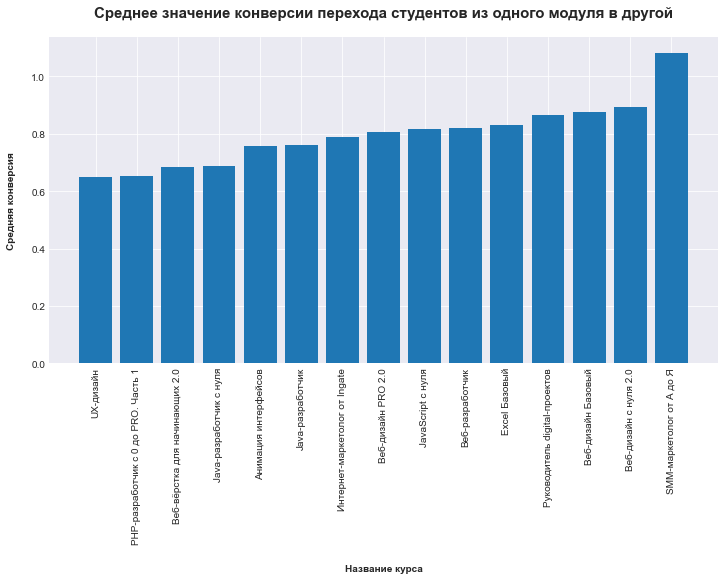

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df_conversion_table['course_title'], df_conversion_table['change'])
plt.title('Среднее значение конверсии перехода студентов из одного модуля в другой', 
          fontweight="bold", pad=20, fontsize=15)
plt.xlabel('Название курса', fontweight="bold", labelpad=20)
plt.ylabel('Средняя конверсия', fontweight="bold", labelpad=15)
plt.xticks(rotation=90);

**4.3.** Построим горизонтальный bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе.

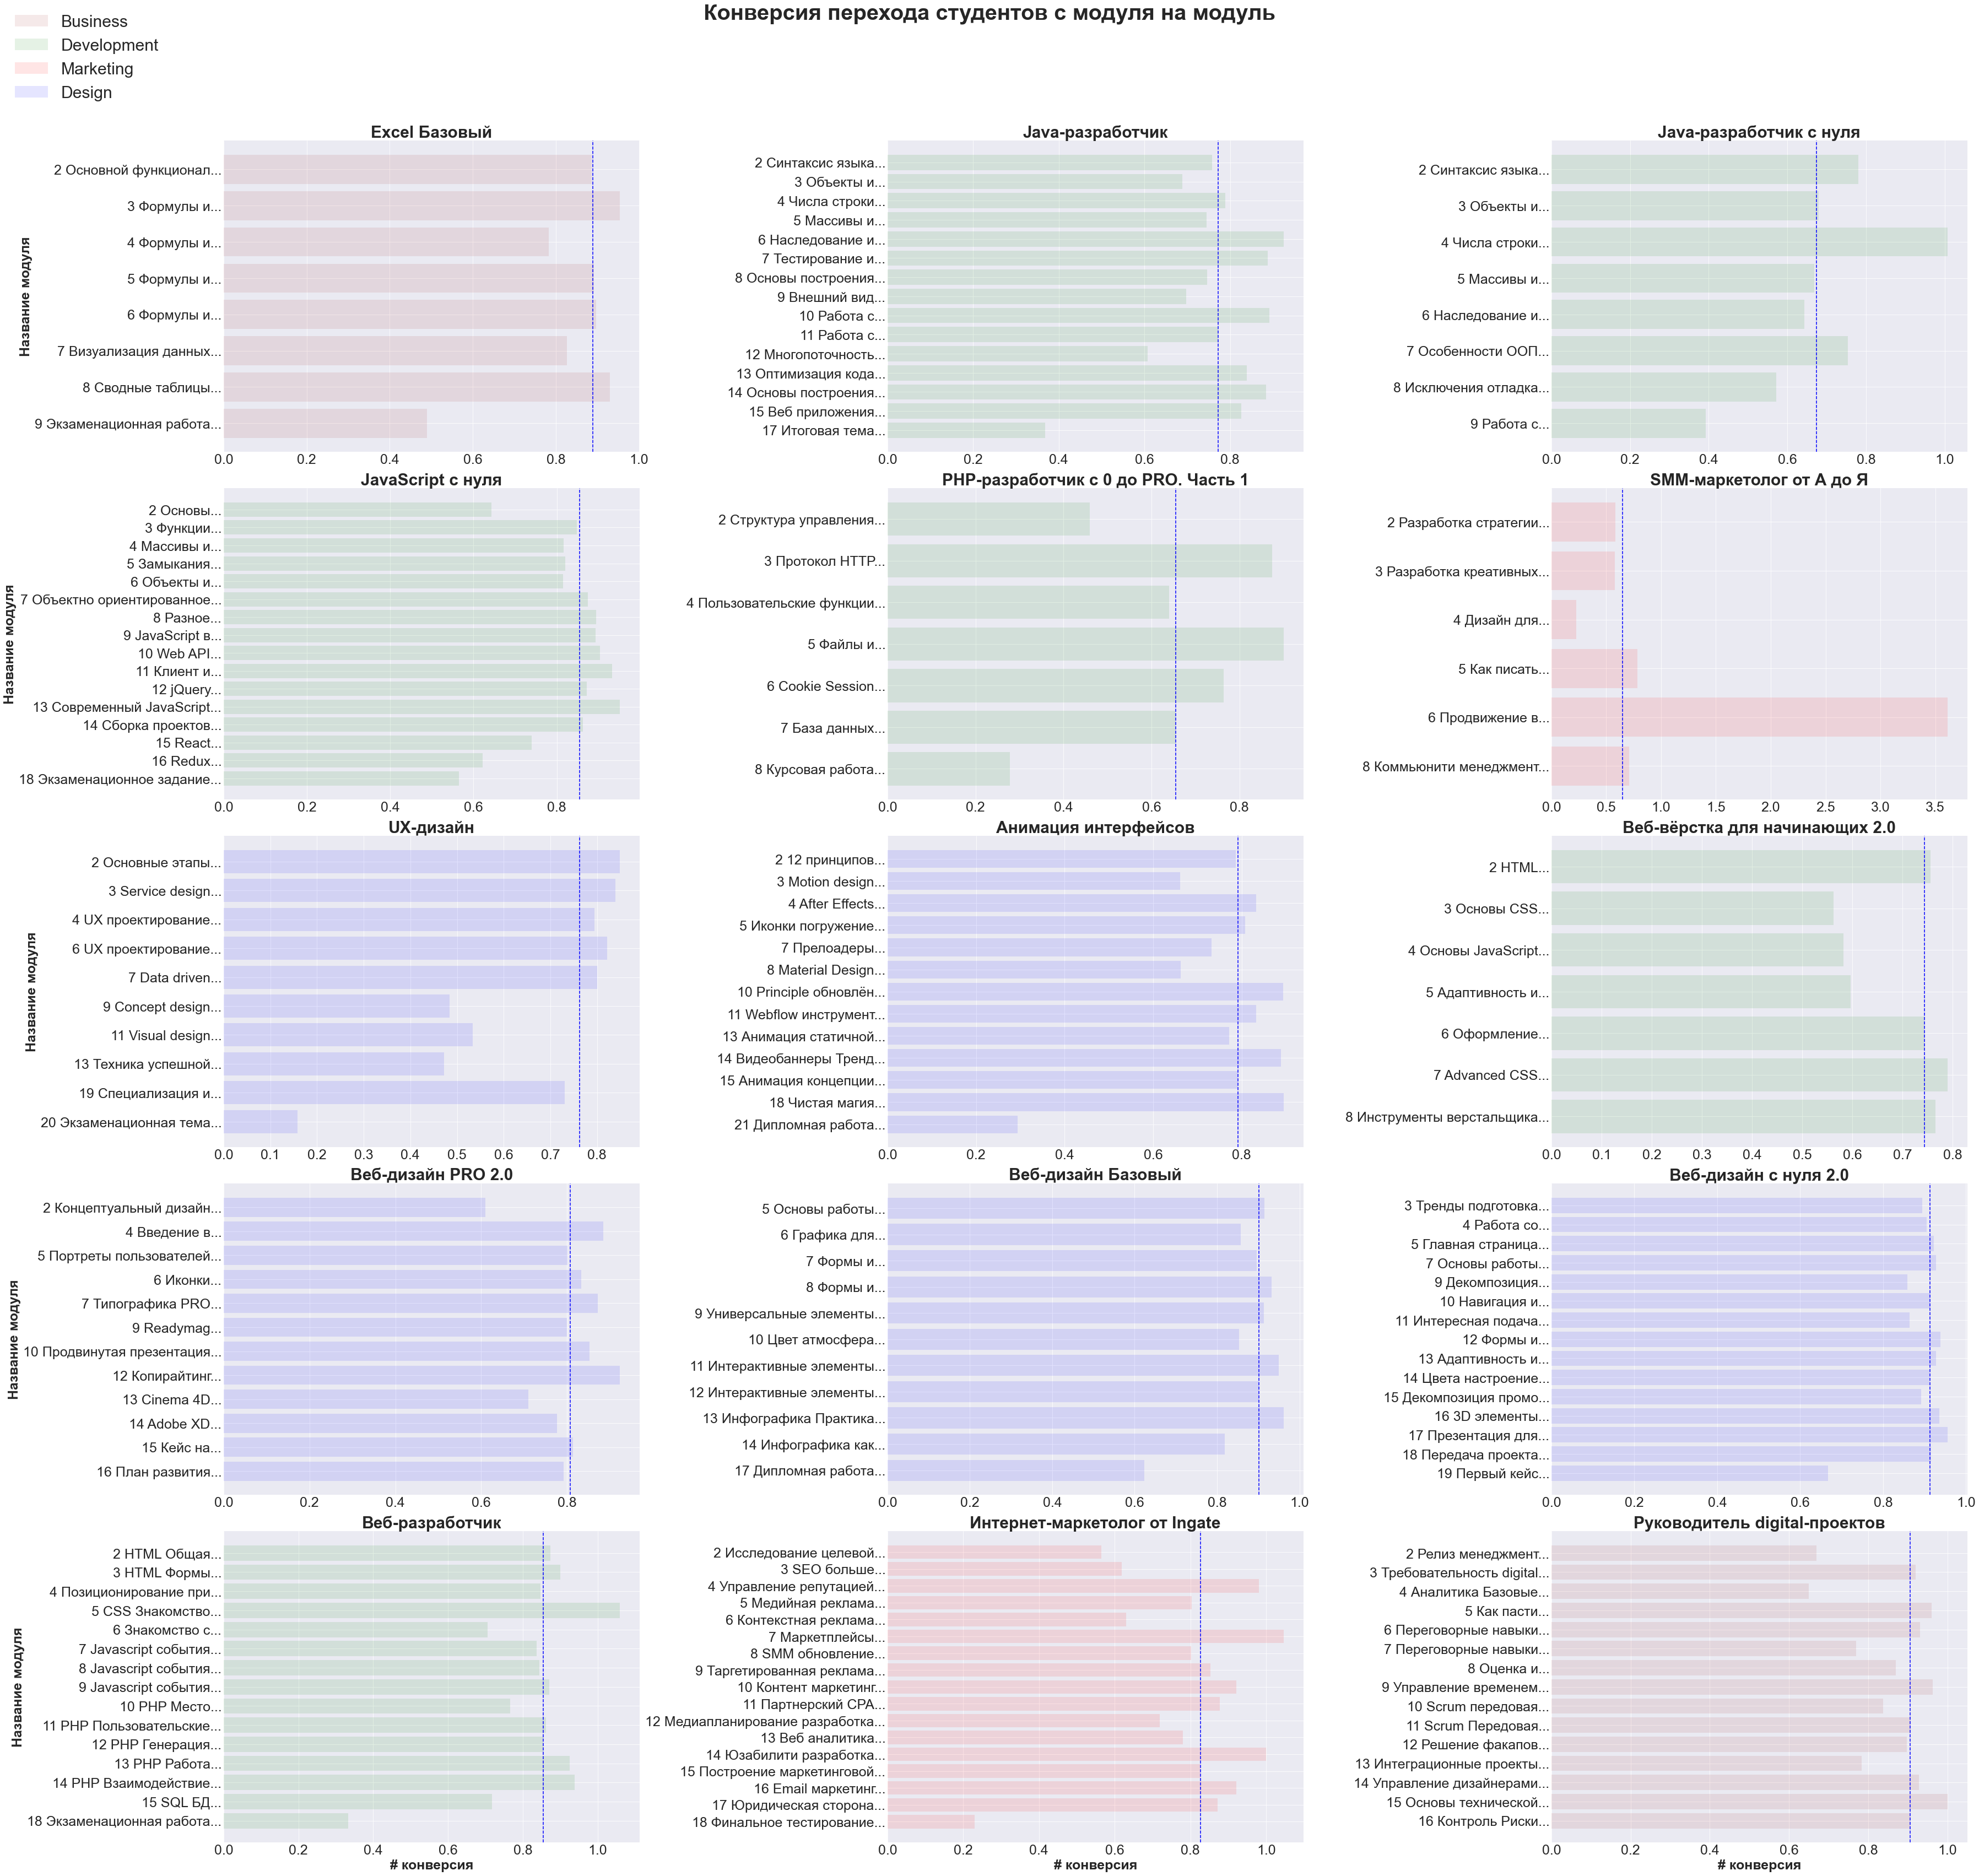

In [41]:
fig, axs = plt.subplots(figsize=(50, 45), nrows=5, ncols=3, sharex=False)
course=0
course_fields_colors = {'Marketing':'red', 'Design':'blue', 'Development':'green', 'Business':'brown'}

for i in range(5):
    for j in range(3):
        ax=axs[i][j]
        data = df_conversion_table2[df_conversion_table2['course_title'] == course_list[course]].sort_values('module_number',ascending=False)
        ax.barh(data['module_name'], data['change'], label=data.course_field.unique()[0], 
                color=course_fields_colors[data.course_field.unique()[0]], alpha=0.1)
        median = data['change'].median()
        ax.axvline(x=median, linestyle='--', color='b')
        ax.set_yticks(data['module_name'])
        ax.set_yticklabels(data['module_name'], fontsize=25)
        ax.tick_params(axis='x', labelsize=25)
        ax.set_title(course_list[course], fontsize=30, fontweight="bold")
        if i == 4:
            ax.set_xlabel('# конверсия', fontsize=25, fontweight="bold") 
        if j == 0:
            ax.set_ylabel('Название модуля', fontsize=25, fontweight="bold")
        course += 1       
fig.suptitle('Конверсия перехода студентов с модуля на модуль', y=1.05, fontsize=40, fontweight='bold')
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handle_list, label_list = [], []
for handle, label in handles_labels:
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
handle_list = [item for sublist in handle_list for item in sublist]
label_list = [item for sublist in label_list for item in sublist]
fig.legend(handle_list, label_list, loc='upper left', fontsize=30)
plt.tight_layout()
plt.show()


**4.4.** На основании рассчитанных значений можно сделать следующие выводы: 

- Чем ниже значение конверсии - тем меньше студентов переходит на следующий модуль курса. 
- Мы выявили два курса с самой низкой средней конверсией -  «UX-дизайн» и «PHP-разработчик с 0 до PRO. Часть 1»
- Курс с самой высокой средней конверсией - это «SMM-маркетолог от А до Я». Предполагается, что из модуля в модуль переходит максимальное количество студентов, но если рассмотреть подробную статистику по модулям данного курса, то можно заметить, что конверсия по всем модулям кроме 6го в среднем достигает 0.5 - это очень низкое значение по сравнению со средними значениями по курсам. Самое низкое значение конверсии имеет четвертый модуль курса «Дизайн для не дизайнеров», в то же время самое высокое значение (3.5) у модуля № 6 "Продвижение в VK, FB, MyTarget". Так же стоит отметить, что данный модуль обладает самой высокой конверсией по сравнению со всеми модулями всех курсов. Из этого мы можем сделать вывод, что 1) среднее значение конверсии по курсу показывает недостовреные данные и необходимо рассматривать данное значение помодульно; 2) Так как конверсия 6го модуля выше единицы, то студенты могут начинать обучение с любого модуля курса; 3) 6й модуль "Продвижение в VK, FB, MyTarget" курса «SMM-маркетолог от А до Я» является наиболее востребованным по сравнению с другими модулями.
- В таком случае, рассмотрим, какой курс действительно обладает самой высокой конверсией. Сразу после курса для SMM-маркетологов идет курс "Веб-дизайн с нуля 2.0". На самом деле, среднее значение конверсии является самым высоким среди всех курсов. Рассматривая статистику по модулям, мы видим, что каждый модуль кроме практической работы обладает конверсией близкой к единице. 
- Последние модули курса, которыми чаще всего являются курсовые/экзаменационные/дипломные работы, обладают самой меньше конверсией по сравнению с другими модулями того же курса.
- Интересно также рассмотреть данные по курсу "UX-дизайн". Модули 2-7 обладают достаточно высокой конверсией - выше 0.7. Начиная с 8 модуля наблюдается резкое снижение значений конверсии - с 0.7 до 0.45. Возвращаясь к графику медианного времени прохождения модулей, мы видим, что на прохождение этих же модулей у студентов уходит намного больше времени по сравнению с остальными. Очевидно, что и значение конверсии и значение медианного времени указывают на сложность данных модулей. 
- В разрезе направлений курсов самой высокой конверсией обладает направление "Бизнес" 

**Обобщая вышесказанное, можно сделать вывод, что значение конверсии перехода с модуля на следующий модуль является одним из главных показателей успешности модуля. Чем меньше значение конверсии, тем меньше студентов переходят на следующий модуль. Это может быть связано с невостребованностью модуля либо его сложностью. Например, последние пять модулей курса "UX-дизайн" показывают низкое значение конверсии и высокое значение медианного времени прохождения модулей**



## 5. Метрика успеваемости 

Иногда студенты берут курсы, которые оказываются для них неподъемными. Это может быть как по причинам недостаточной изначальной подготовки, так и по причинам, связанным с низкой мотивацией студента. Для улучшения качества контента полезно выявить причину.

**Метрика 1. Переход с одного курса на другой**

Для улучшения качества контента курсов можно рассмотреть переход студентов с одного курса на другой и как часто это происходит. Какие курсы чаще всего покидают студенты? Проходя какой модуль студенты принимают решение покинуть курс? 

Для начала найдем общее количество модулей в каждом из курсов:

In [42]:
modules_number = df_merged.groupby('course_title')['module_number'].nunique().reset_index()
modules_number

,course_title,module_number
0,Excel Базовый,9
1,Java-разработчик,17
2,Java-разработчик c нуля,9
3,JavaScript с нуля,18
4,PHP-разработчик с 0 до PRO. Часть 1,8
5,SMM-маркетолог от А до Я,11
6,UX-дизайн,20
7,Анимация интерфейсов,21
8,Веб-вёрстка для начинающих 2.0,8
9,Веб-дизайн PRO 2.0,17


Чтобы выявить тех студентов, которые приняли решение поменять курс в течение работы над предыдущим, нам необходимо выбрать только незаконченные курсы студентов:

In [43]:
df_course_change = df_merged.groupby(['student_id', 'course_title']).agg({
    'start_date': 'min', 'finish_date': 'max', 'module_number':'max'}).reset_index()

In [44]:
df_course_change = df_course_change.merge(modules_number, how='inner', on='course_title').rename(
            columns={'module_number_x':'last_module',
                    'module_number_y': 'modules_number'})
df_course_change = df_course_change.drop(df_course_change.index[df_course_change['last_module'] == df_course_change['modules_number']])

Для каждого студента найдем количество приобретенных им курсов. Из датасета удаляем данные по студентам, котороые приобрели только 1 курс(не совершали переход):

In [45]:
df_courses_number = df_course_change.groupby('student_id')['course_title'].nunique().reset_index()
df_courses_number = df_courses_number[df_courses_number['course_title'] > 1]

In [46]:
df_course_change = df_courses_number.merge(df_course_change, on='student_id', how='left').rename(
            columns={'course_title_x':'courses_started',
                    'course_title_y': 'course_title'}).sort_values(['student_id', 'start_date']).set_index('student_id')

In [47]:
df_course_change['start_date'] = pd.to_datetime(df_course_change['start_date']).dt.strftime('%Y-%m-%d')
df_course_change['finish_date'] = pd.to_datetime(df_course_change['finish_date']).dt.strftime('%Y-%m-%d')

Удялем данные студентов, которые с самого начала купили сразу несколько курсов(не совершали переход):

In [48]:
df_course_change = df_course_change.drop(
    df_course_change.index[df_course_change['start_date'] == df_course_change['start_date'].shift()]).sort_values(['student_id', 'start_date']).reset_index()

Добавим в датасет информацию о статусе прохождения курса в процентах:

In [49]:
df_course_change['prct_completion'] = round(df_course_change['last_module'] / df_course_change['modules_number'] * 100)

Мы видим, что некоторые студенты приобретают новые курсы, пройдя уже больше половины предыдущего. Стоит предположить, что студенты успешно справляются с прохождением первоначального курса и приобретают новый для получения дополнительных знаний, а не из-за возникающих трудностей:

In [50]:
df_course_change = df_course_change.set_index('student_id')
df_course_change = df_course_change.drop(df_course_change.index[
    df_course_change['prct_completion'] > 50
]).reset_index()

Посмотрим, на каком модуле студенты, не прошедшие половину курса, чаще всего меняют направление:

In [51]:
last_module_change = df_course_change.groupby('student_id')[['course_title', 'last_module']].first().reset_index()
int(last_module_change.last_module.mean())

3

Рассмотрим, какие курсы чаще всего покидают студенты и найдем их количество:

In [52]:
df_courses = df_course_change.groupby('student_id')['course_title'].apply(lambda df_course_change: df_course_change.reset_index(drop=True)).unstack().reset_index()
df_courses.groupby(0)['student_id'].nunique().reset_index().sort_values('student_id', ascending=False)

,0,student_id
1,Java-разработчик,171
12,Веб-разработчик,106
8,Веб-вёрстка для начинающих 2.0,55
11,Веб-дизайн с нуля 2.0,55
13,Интернет-маркетолог от Ingate,36
10,Веб-дизайн Базовый,31
3,JavaScript с нуля,28
9,Веб-дизайн PRO 2.0,22
4,PHP-разработчик с 0 до PRO. Часть 1,20
6,UX-дизайн,20


Чтобы сделать вывод о возможных причинах перехода студентов с одного курса на другой, стоит рассмотреть это в комбинации преобретенный курс > новый курс. Выберем только те изменения, которые произошли больше 5 раз, все остальные изменения сгруппируем под названием "Другие":

In [53]:
df_courses['change'] = df_courses[0] + " > " + df_courses[1]
df_courses_change = df_courses.groupby('change')['student_id'].nunique().reset_index().sort_values('student_id', ascending=False)
df_courses_change['change'] = np.where(df_courses_change['student_id'] <= 5, 'Другие', df_courses_change['change'])
df_courses_change = df_courses_change.groupby('change')['student_id'].sum().reset_index().sort_values('student_id')

Построим горизонтальный bar-chart, отражающий количество студентов, которые поменяли 

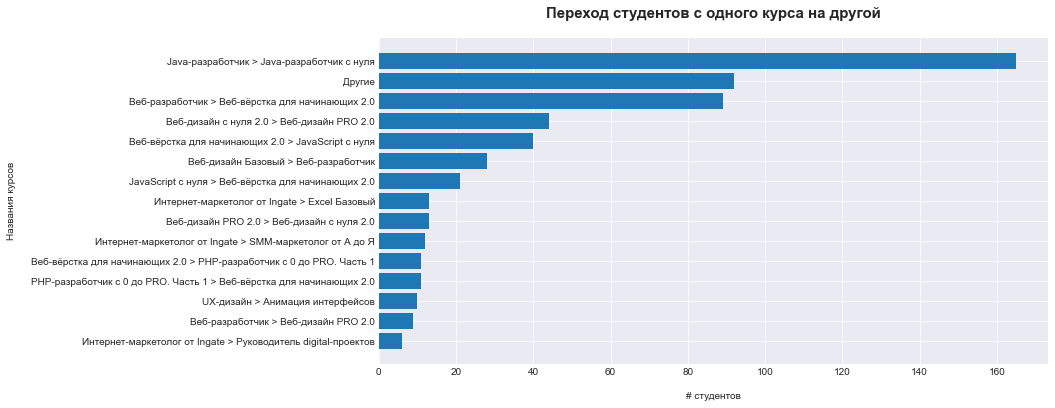

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
ax.barh(df_courses_change.change, df_courses_change.student_id)
plt.title('Переход студентов с одного курса на другой', fontweight="bold", pad=20, fontsize=15)
plt.xlabel('# студентов', labelpad=15)
plt.ylabel('Названия курсов', labelpad=15)
plt.show();

**5.1.** На основании рассчитанных значений можно сделать следующие выводы:
- Cвыше 160 студентов, которые приобрели курс "Java-разработчик" не проходят его до конца и переходят на курс "Java-разработчик с нуля". Можно предположить, что первоначально приобретенный курс не был предназначен для начинающих програмистов и стал для студентов неподьъемным.
- Похожая проблема возникла у студентов курса "Веб-дизайн PRO 2.0", которые перешли на курс "Веб-дизайн с нуля"
- С обратной проблемой столкнулись студенты, которые приобрели "базовые" курсы для начинающих. Так, студенты курса "Веб-дизайн с нуля 2.0" перешли на "Веб-дизайн PRO 2.0", а их коллеги из курса "Веб-дизан Базовый" сменили курс на "Веб-разработчик"
- Более интересны изменения курсов из различных областей знаний. Мы видим, что студенты, начавшие курс в маркетинге перешли на курс в направлении бизнес (Excel/руководитель digital-проектов)

**Обобщая вышесказанное, можно сделать вывод, что частый переход студентов с одного курса на другой может полслужить сигналом для создателей курса о необходимости дополнительного входного тестирования перед покупкой курса. Так, студенты, которые являлись новичками в Java-разработке не оказались на курсе для продвинутых.**

**Метрика 2. Длительность прохождения модулей курса**<br>
Для выявления студентов, которые сталкиваются с проблемами с прохождением курсов, можно найти медианное время прохождения модуля, вне зависимости от наличия домашнего задания в модуле и отклонение от медианного времени. Если  реальная длительность прохождения модуля превышает медианное время в два раза, значит студент мог столкнуться с трудностями. Если данное отношение превышает 10, то студент уже долгое время не был активен на платформе Skillbox. Если отношение > 20, скорее всего юзер полностью отказался от прохождения курса.

Для начала найдем медианное время прохождения курса:

In [55]:
df_time = df_merged.groupby(['course_title', 'module_number', 'student_id']).agg({
    'start_date':'min', 
    'finish_date':'max'}).reset_index()

In [56]:
df_time['duration'] = df_time.finish_date - df_time.start_date
df_avg_time = df_time.groupby(['course_title', 'module_number'])['duration'].median().reset_index().rename(columns={
    'duration':'avg_duration'
})
df_time = df_time.merge(df_avg_time, on=['course_title', 'module_number'], how='inner')
df_time = df_time[df_time['finish_date'].notnull()]

Получим реальное время прохождения модуля курса и добавим в датасет комментарии для кураторов и создателей курса:
- "No help required" - если время прохождения курса меньше чем в 2 раза превышает медианное время. Студентам с таким комменатрием не требуется какая-либо помощь. 
- "Help might be required" - если время прохождения курса больше чем медианное время в 2 раза, но меньше него в 10 раз. Скорее всего, студенту необходима помощь при прохождении модуля.
- "Inactive for a long time" - отношение времени прохождения модуля к медианному времени выше 10, но меньше 20. Студент курса долго не заходит на платформу и, возможно, потерял мотивацию к обучению.
- "Module seems to be onhold" - отношение превышает 20, что значит, что студент неактивен на платформе в течение долгого времени и скорее всего отказался от дальнейшего прохождения курса

In [57]:
def if_difficulties(time, avg_time):
    deviation = (time / np.timedelta64(1, 'D')) / (avg_time / np.timedelta64(1, 'D'))  
    if deviation < 2:
        return "No help required"
    elif 2 < deviation < 10:
        return "Help might be required"
    elif 10 < deviation < 20:
        return "Inactive for a long time"
    else:
        return "Module seems to be onhold"

In [58]:
df_time['difficulties'] = df_time.apply(lambda x: if_difficulties(x.duration, x.avg_duration), axis=1)
df_time = df_time.dropna()

Для лучшего обзора построим bar-chart, отражающий статус студента:

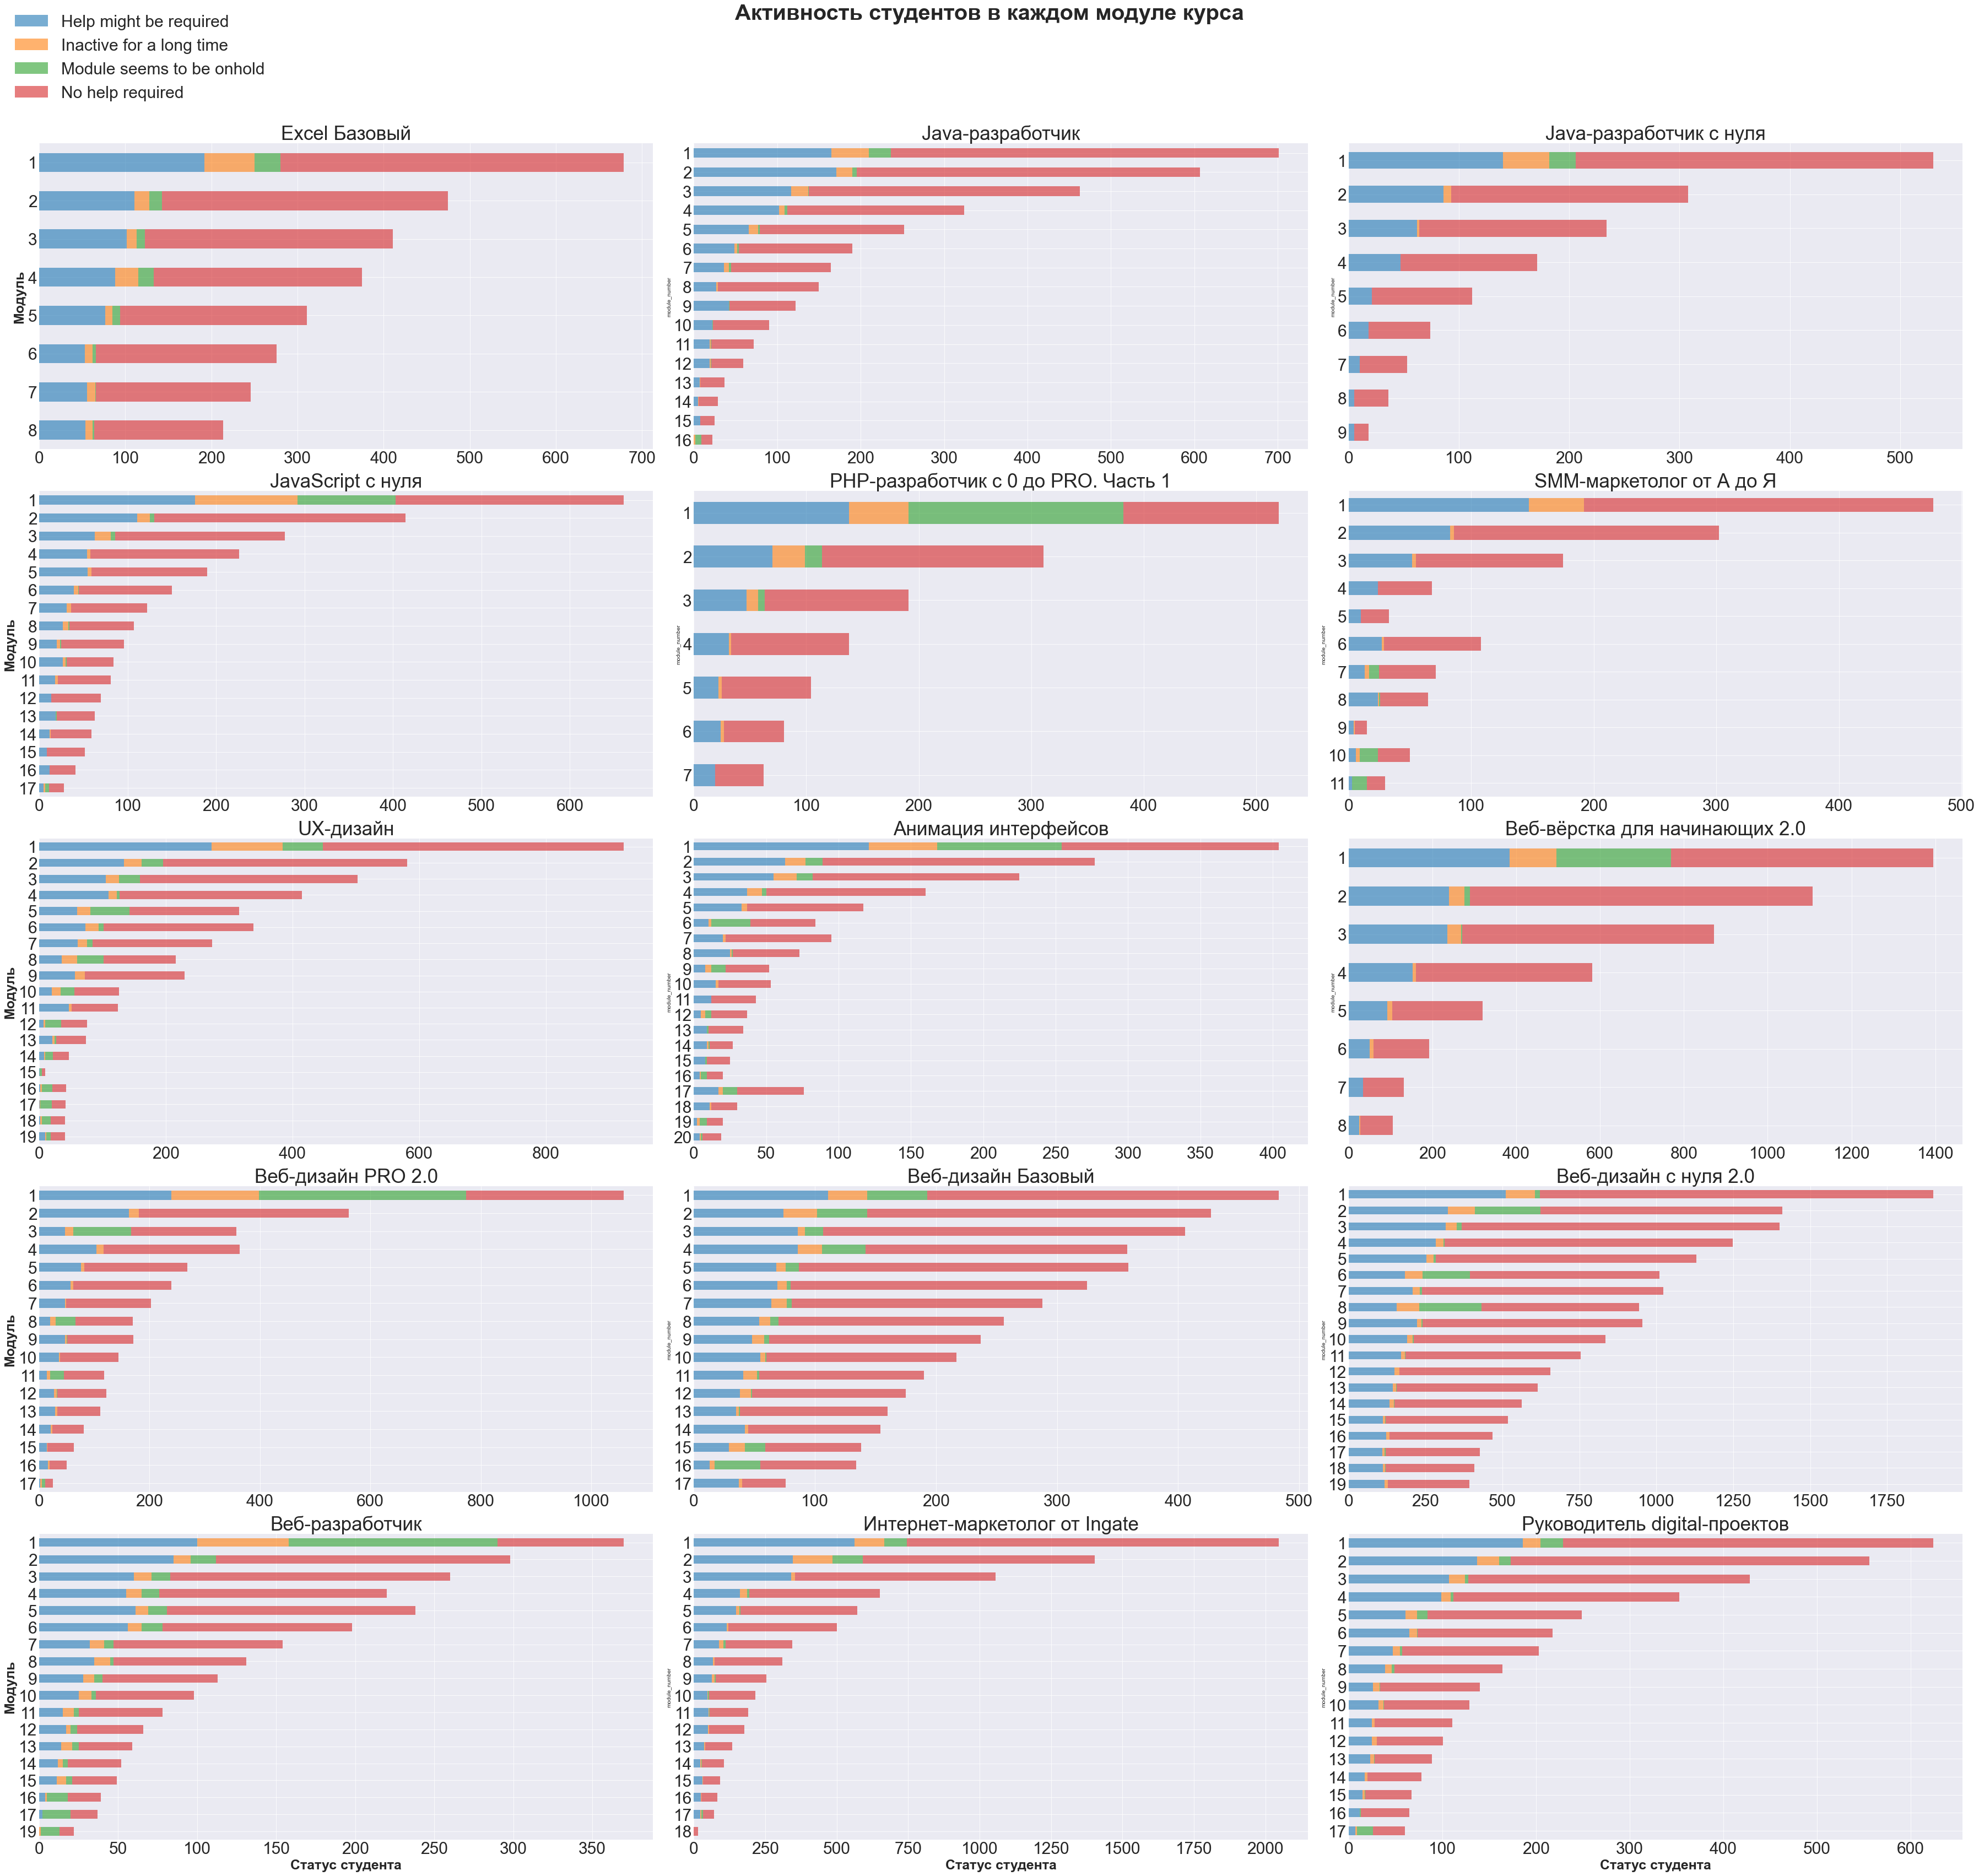

In [59]:
fig, axs = plt.subplots(figsize=(50, 45), nrows=5, ncols=3, sharex=False)
course=0

for i in range(5):
    for j in range(3):
        data = df_time[df_time['course_title'] == course_list[course]]\
        .groupby(['course_title', 'module_number', 'difficulties'])['difficulties']\
        .count()\
        .unstack('difficulties')\
        .sort_values(by=['Help might be required', 'Inactive for a long time', 
                                       'Module seems to be onhold', 'No help required'])[-20:]\
        .reset_index()\
        .sort_values('module_number', ascending=False)\
        .set_index('module_number')
        plot = data.plot.barh(ax=axs[i][j], stacked=True, alpha=0.6, title=course_list[course], fontsize=30)
        plot.get_legend().remove()
        plot.title.set_size(35) 
        if i == 4:
            plot.set_xlabel('Статус студента', fontsize=25, fontweight="bold") 
        if j == 0:
            plot.set_ylabel('Модуль', fontsize=25, fontweight="bold")
        course += 1       
fig.suptitle('Активность студентов в каждом модуле курса', y=1.05, fontsize=40, fontweight='bold')
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handle_list, label_list = [], []
for handle, label in handles_labels:
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
handle_list = [item for sublist in handle_list for item in sublist]
label_list = [item for sublist in label_list for item in sublist]
fig.legend(handle_list, label_list, loc='upper left', fontsize=30)
plt.tight_layout()
plt.show()

**5.2.** На основании рассчитанных значений можно сделать следующие выводы:
- На первых модулях курсов мы видим большое количество студентов, которым требуется намного больше медианного времени для прохождения (студенты со статусом "Help might be required"). Далее количество таких студентов снижается для всех курсов.
- Также мы видим наличие неактивных студентов в первом модуле курсов. Так, например, студентам, которые приобрели курсы "Веб-разработчик", "Веб-дизайн PRO 2.0", "PHP-разработчик с 0 до PRO", понадобилось намного больше медианного времени для прохождения первого модуля. 
- Можно отметить "сложные" курсы, где в рамках каждого модуля есть студенты, которым необходима помощь (статус help might be required). На курсе "Веб-дизайн с нуля 2.0" количество таких студентов не уменьшается в течение прохождения курса, а находится на том же уровне. 

**Обобщая вышесказанное, можно сделать вывод, что статус студента, основанный на отношении времени прохождения модуля к медианному времени, может быть полезным для создателей курса. Так, например, анализируя время прохождения первых модулей курса, можно заметить, что существуют студенты, которые сталкиваются с трудностями при прохождении. Возможно, новым студентам необходимо больше времени, чтобы познакомиться с платформой, процедурой отправки домашнего задания и т.д.** 